Clean an run the normalizing flow on all latent space

## Top of notebook

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp

import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import cluster, datasets, mixture
from sklearn.preprocessing import StandardScaler

from scipy.stats import norm
import matplotlib.mlab as mlab

tfk = tf.keras
tfkl = tfk.layers
tfd = tfp.distributions
tfb = tfp.bijectors

#sns.set_style("white")
#sns.set_context("notebook")
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

In [2]:
tfd = tfp.distributions
tfb = tfp.bijectors

Try this notebook : https://dirmeier.github.io/etudes/normalizing_flows.html

In [3]:
for i in ([512,512]):
    print(i)

512
512


In [4]:
(np.arange(512) % max(1, 32 - 1) + min(1, 32 - 1))

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,  1,  2,  3,
        4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
       21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,  1,  2,  3,  4,  5,  6,
        7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
       24, 25, 26, 27, 28, 29, 30, 31,  1,  2,  3,  4,  5,  6,  7,  8,  9,
       10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,
       13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29,
       30, 31,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,  1,
        2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,  1,  2,  3,  4,
        5,  6,  7,  8,  9

In [5]:
len(np.arange(512) % max(1, 32 - 1) + min(1, 32 - 1))

512

In [6]:
def make_degrees(p, hidden_dims):
    m = [tf.constant(range(1, p + 1))]
    for dim in hidden_dims:                
        n_min = min(np.min(m[-1]), p - 1)
        degrees = (np.arange(dim) % max(1, p - 1) + min(1, p - 1))
        degrees = tf.constant(degrees, dtype="int32")
        m.append(degrees)
    return m

In [7]:
def make_masks(degrees):
    masks = [None] * len(degrees)
    for i, (ind, outd) in enumerate(zip(degrees[:-1], degrees[1:])):
        masks[i] = tf.cast(ind[:, tf.newaxis] <= outd, dtype="float32")        
    masks[-1] = tf.cast(degrees[-1][:, np.newaxis] < degrees[0], dtype="float32")
    return masks

In [8]:
def make_constraint(mask):    
    def _constraint(x):
        return mask * tf.identity(x)
    return _constraint

In [9]:
def make_init(mask):
    def _init(shape, dtype=None):
        return mask * tf.keras.initializers.GlorotUniform(23)(shape)
    return _init

In [10]:
def make_network(p, hidden_dims, params):
    masks = make_masks(make_degrees(p, hidden_dims))    
    masks[-1] = tf.tile(masks[-1][..., tf.newaxis], [1, 1, params])
    masks[-1] = tf.reshape(masks[-1], [masks[-1].shape[0], p * params])
    
    network =  tf.keras.Sequential([
        tf.keras.layers.InputLayer((p,))
    ])
    for dim, mask in zip(hidden_dims + [p * params], masks):
        layer = tf.keras.layers.Dense(
            dim,
            kernel_constraint=make_constraint(mask),
            kernel_initializer=make_init(mask),
            activation=tf.nn.leaky_relu)
        network.add(layer)    
    network.add(tf.keras.layers.Reshape([p, params]))#network.add(tf.keras.layers.Reshape([p, params]))
    
    return network

In [11]:
class MAF(tfb.Bijector):
    def __init__(self, shift_and_log_scale_fn, name="maf"):
        super(MAF, self).__init__(forward_min_event_ndims=1, name=name)
        self._shift_and_log_scale_fn = shift_and_log_scale_fn
        
    def _shift_and_log_scale(self, y):
        params = self._shift_and_log_scale_fn(y)          
        shift, log_scale = tf.unstack(params, num=2, axis=-1)
        return shift, log_scale
        
    def _forward(self, x):
        y = tf.zeros_like(x, dtype=tf.float32)
        for i in range(x.shape[-1]):            
            shift, log_scale = self._shift_and_log_scale(y)            
            y = x * tf.math.exp(log_scale) + shift
        return y

    def _inverse(self, y):
        shift, log_scale = self._shift_and_log_scale(y)
        return (y - shift) * tf.math.exp(-log_scale)

    def _inverse_log_det_jacobian(self, y):
        _, log_scale = self._shift_and_log_scale(y)
        return -tf.reduce_sum(log_scale, axis=self.forward_min_event_ndims)

## Test of notebook example

In [38]:
from sklearn import cluster, datasets, mixture
from sklearn.preprocessing import StandardScaler

n = 10000
X, _ = datasets.make_moons(n_samples=n, noise=.05)
X = StandardScaler().fit_transform(X)

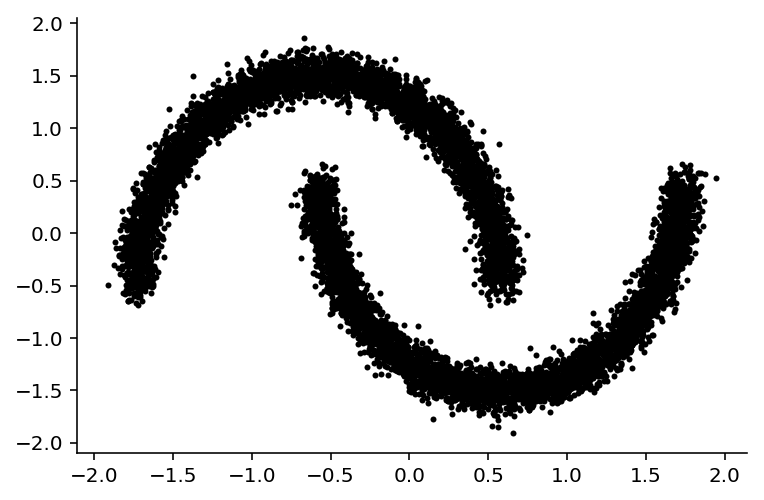

In [39]:
ax = sns.scatterplot(X[:, 0], X[:, 1], color="black", marker='.', linewidth=0);
sns.despine();

In [59]:
hidden_dim = [512, 512]  
layers = 2
bijectors = []
for i in range(0, layers):
    made = make_network(2, hidden_dim, 2)
    bijectors.append(MAF(made))
    bijectors.append(tfb.Permute(permutation=[1, 0])) 
    
bijectors = tfb.Chain(bijectors=list(reversed(bijectors[:-1])))

In [60]:
distribution = tfd.TransformedDistribution(
    distribution=tfd.Normal(loc=0., scale=1.),
    bijector=bijectors,
    event_shape=[2]
)

In [61]:
x_ = tfkl.Input(shape=(2,), dtype=tf.float32)
log_prob_ = distribution.log_prob(x_)
model = tfk.Model(x_, log_prob_)

model.compile(optimizer=tf.optimizers.Adam(), loss=lambda _, log_prob: -log_prob)

In [62]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_37 (InputLayer)           [(None, 2)]          0                                            
__________________________________________________________________________________________________
sequential_25 (Sequential)      (None, 2, 2)         266244      input_37[0][0]                   
                                                                 input_37[0][0]                   
                                                                 input_37[0][0]                   
__________________________________________________________________________________________________
tf_op_layer_unstack_17 (TensorF [(None, 2), (None, 2 0           sequential_25[1][0]              
____________________________________________________________________________________________

In [52]:
_ = model.fit(x=X,
              y=np.zeros((X.shape[0], 0), dtype=np.float32),
              batch_size= X.shape[0],
              epochs=1000,
              steps_per_epoch=1,
              verbose=1,
              shuffle=False)

Train on 10000 samples
Epoch 1/1000
10000/10000 [==============================] - 0s 40us/sample - loss: 2.0485
Epoch 2/1000
10000/10000 [==============================] - 0s 36us/sample - loss: 2.0479
Epoch 3/1000
10000/10000 [==============================] - 0s 35us/sample - loss: 2.0460
Epoch 4/1000
10000/10000 [==============================] - 0s 40us/sample - loss: 2.0399
Epoch 5/1000
10000/10000 [==============================] - 0s 34us/sample - loss: 2.0392
Epoch 6/1000
10000/10000 [==============================] - 0s 36us/sample - loss: 2.0399
Epoch 7/1000
10000/10000 [==============================] - 0s 34us/sample - loss: 2.0835
Epoch 8/1000
10000/10000 [==============================] - 0s 37us/sample - loss: 2.0433
Epoch 9/1000
10000/10000 [==============================] - 0s 35us/sample - loss: 2.0825
Epoch 10/1000
10000/10000 [==============================] - 0s 35us/sample - loss: 2.0811
Epoch 11/1000
10000/10000 [==============================] - 0s 36us/sample 

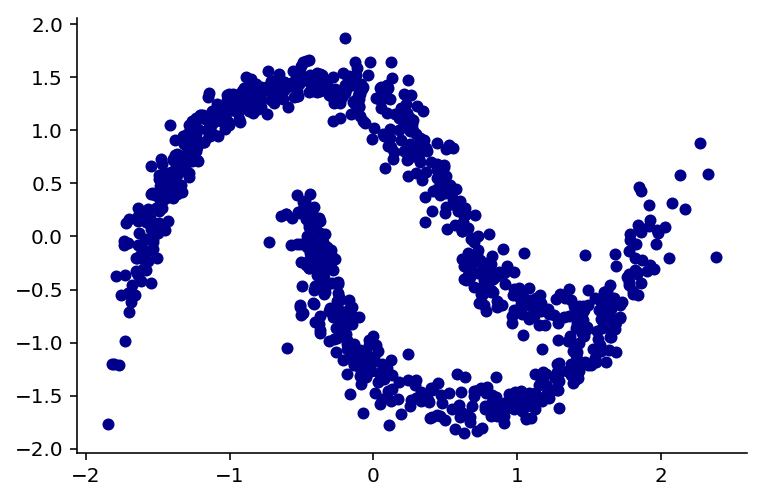

In [53]:
samples = distribution.sample(1000)
samples = StandardScaler().fit_transform(samples)
sns.scatterplot(samples[:, 0], samples[:, 1], color='darkblue', marker='o', linewidth=0);
sns.despine();

## Test from latent space of VAE

In [12]:
z = np.load('latent_space.npy',mmap_mode = 'c')
z_2 = np.load('latent_space_2.npy',mmap_mode = 'c')

z = np.concatenate((z,z_2), axis = 0)

/sps/lsst/users/barcelin/miniconda/envs/python_cpu6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/sps/lsst/users/barcelin/miniconda/envs/python_cpu6/lib/python3.6/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  


mu: -0.0029954666276466417 sigma: 1.606304417544382
mu: 0.14648211557320126 sigma: 1.385527738249563
mu: -0.002404891142242835 sigma: 1.63748863033781


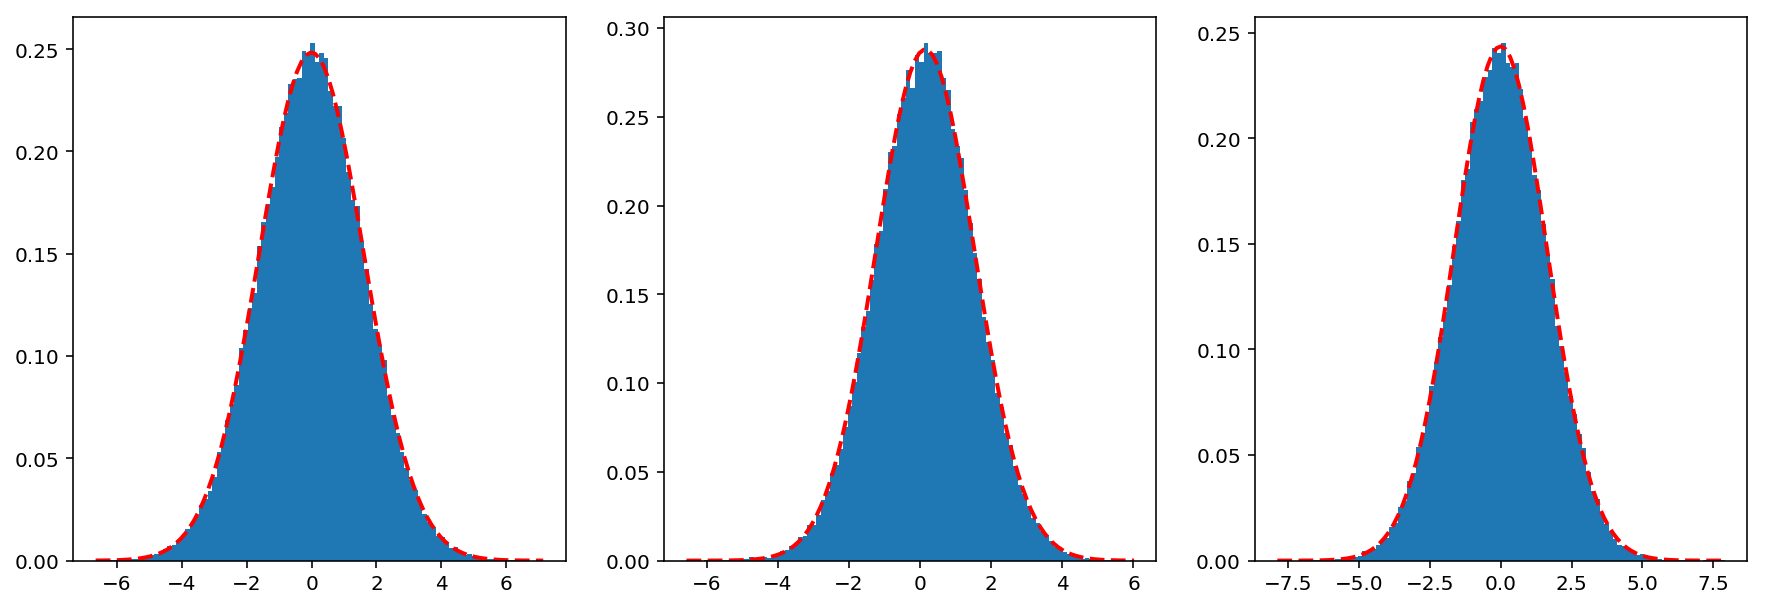

In [10]:
fig, axes = plt.subplots(1,3, figsize = (15,5))

for i in range (3):
    (mu, sigma) = norm.fit(z[:,i])
    n, bins, patches = axes[i].hist(z[:,i], normed = True, bins = 100)
    z_plt = mlab.normpdf( bins, mu, sigma)

    axes[i].plot(bins, z_plt, 'r--', linewidth=2)
    print('mu: '+str(mu)+' sigma: '+str(sigma))

## First two dimensions of latent space

In [11]:
#z_test = StandardScaler().fit_transform(z[:1000,:2])

In [11]:
hidden_dim = [512,512]  
layers =3
bijectors = []
for i in range(0, layers):
    made = make_network(2, hidden_dim, 2)
    bijectors.append(MAF(made))
    bijectors.append(tfb.Permute(permutation=[1, 0])) 
    
bijectors = tfb.Chain(bijectors=list(reversed(bijectors[:-1])))

In [12]:
distribution = tfd.TransformedDistribution(
    distribution=tfd.Normal(loc=0., scale=1.),
    bijector=bijectors,
    event_shape=[2]
)

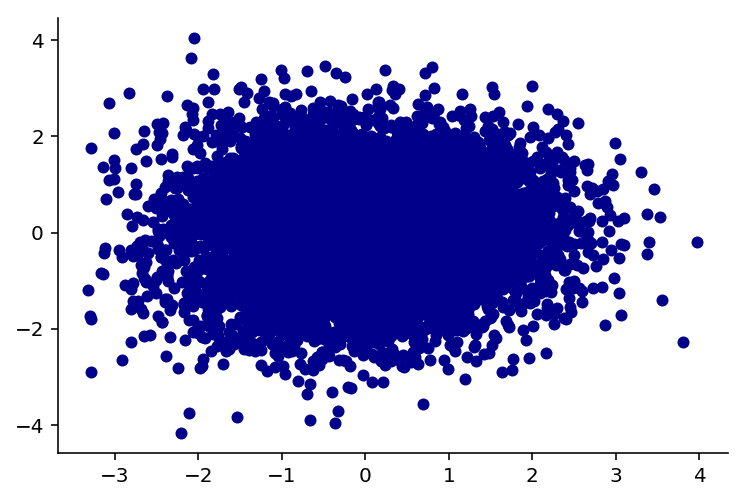

In [13]:
samples = distribution.sample(10000)
#samples = StandardScaler().fit_transform(samples)
sns.scatterplot(samples[:, 0], samples[:, 1], color='darkblue', marker='o', linewidth=0);
sns.despine();

/sps/lsst/users/barcelin/miniconda/envs/python_cpu6/lib/python3.6/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  


mu: 0.016757684 sigma: 1.012335
mu: 0.04786795 sigma: 1.0267475


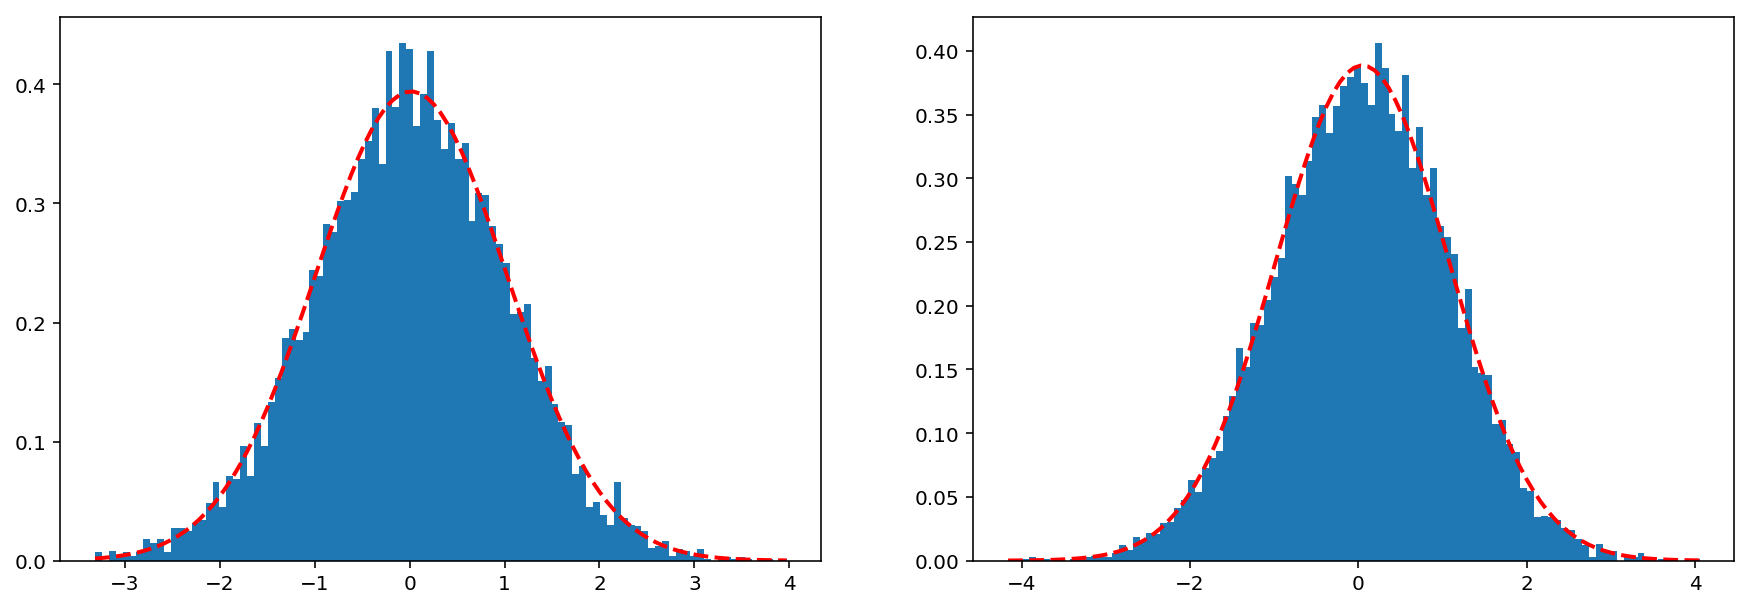

In [14]:
#z_test = StandardScaler().fit_transform(z[:,4:6])

fig, axes = plt.subplots(1,2, figsize = (15,5))

for i in range (2):
    (mu, sigma) = norm.fit(samples[:,i])
    n, bins, patches = axes[i].hist(samples[:,i], normed = True, bins = 100)
    z_plt = mlab.normpdf( bins, mu, sigma)

    axes[i].plot(bins, z_plt, 'r--', linewidth=2)
    print('mu: '+str(mu)+' sigma: '+str(sigma))

In [15]:
x_ = tfkl.Input(shape=(2,), dtype=tf.float32)
log_prob_ = distribution.log_prob(x_)
model = tfk.Model(x_, log_prob_)

model.compile(optimizer=tf.optimizers.Adam(), loss=lambda _, log_prob: -log_prob)

In [16]:
_ = model.fit(x=z[:10000,:2],
              y=np.zeros((z[:,:2].shape[0], 0), dtype=np.float32),
              batch_size= z[:,:2].shape[0],
              epochs=50,
              steps_per_epoch=1,
              verbose=1, 
              shuffle=False)

Train on 100000 samples
Epoch 1/50
100000/100000 [==============================] - 10s 97us/sample - loss: 4.0378
Epoch 2/50
100000/100000 [==============================] - 6s 60us/sample - loss: 3.9468
Epoch 3/50
100000/100000 [==============================] - 6s 60us/sample - loss: 3.8438
Epoch 4/50
100000/100000 [==============================] - 6s 60us/sample - loss: 3.7988
Epoch 5/50
100000/100000 [==============================] - 6s 62us/sample - loss: 3.7970
Epoch 6/50
100000/100000 [==============================] - 6s 61us/sample - loss: 3.7683
Epoch 7/50
100000/100000 [==============================] - 6s 59us/sample - loss: 3.7328
Epoch 8/50
100000/100000 [==============================] - 7s 65us/sample - loss: 3.6978
Epoch 9/50
100000/100000 [==============================] - 6s 61us/sample - loss: 3.6721
Epoch 10/50
100000/100000 [==============================] - 6s 64us/sample - loss: 3.6613
Epoch 11/50
100000/100000 [==============================] - 7s 67us/sampl

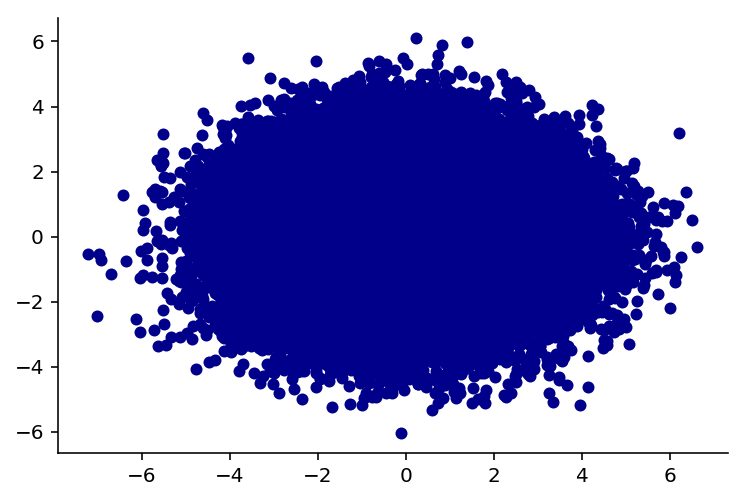

In [17]:
samples = distribution.sample(100000)
#samples = StandardScaler().fit_transform(samples)
sns.scatterplot(samples[:, 0], samples[:, 1], color='darkblue', marker='o', linewidth=0);
sns.despine();

In [18]:
samples.shape

TensorShape([100000, 2])

/sps/lsst/users/barcelin/miniconda/envs/python_cpu6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/sps/lsst/users/barcelin/miniconda/envs/python_cpu6/lib/python3.6/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  
/sps/lsst/users/barcelin/miniconda/envs/python_cpu6/lib/python3.6/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  from ipykernel import kernelapp as app


mu distrib transformed: 9.866333e-07 sigma distrib transformed: 1.5991259
mu z: -0.0029954666276466417 sigma z: 1.606304417544382
mu distrib transformed: 0.13718922 sigma distrib transformed: 1.3939236
mu z: 0.14648211557320126 sigma z: 1.385527738249563


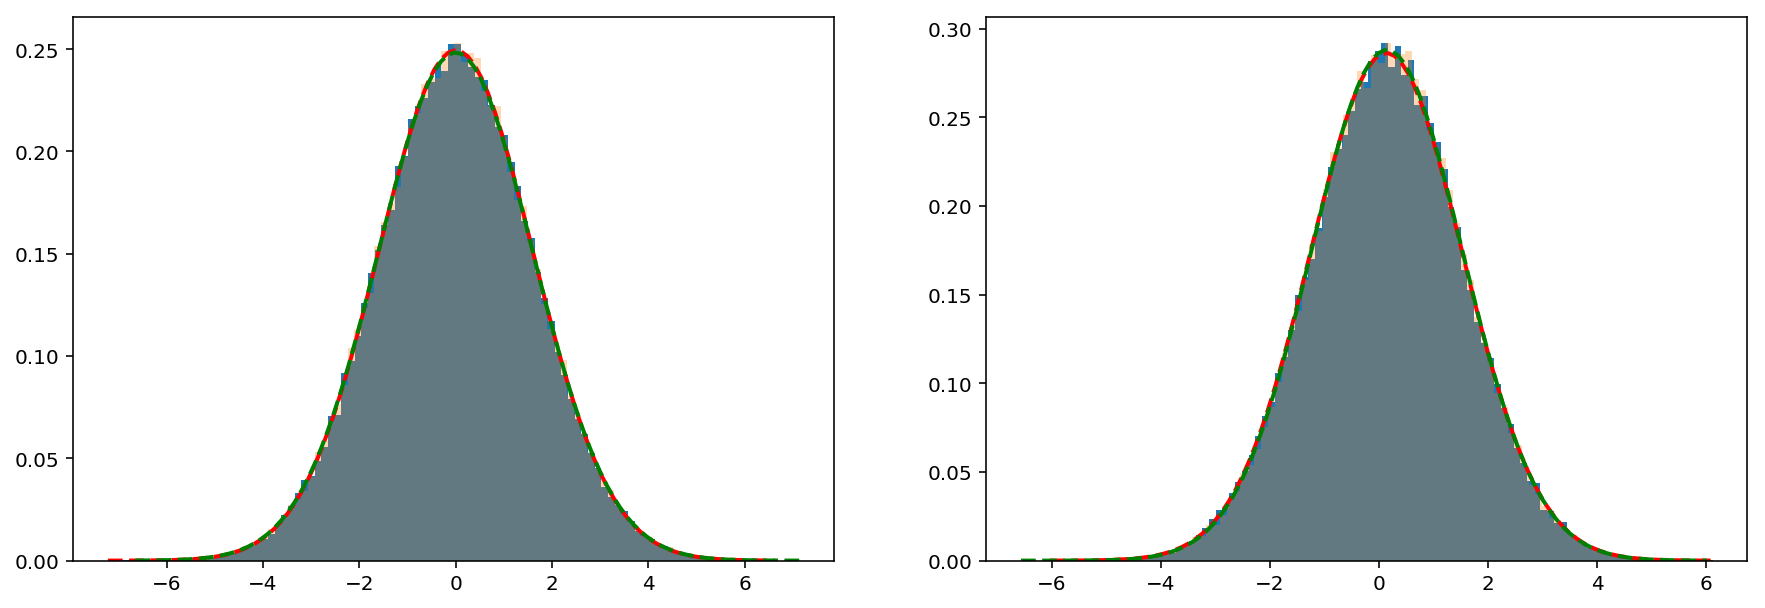

In [19]:
#z_test = StandardScaler().fit_transform(z[:,4:6])

fig, axes = plt.subplots(1,2, figsize = (15,5))

for i in range (2):
    (mu, sigma) = norm.fit(samples[:,i])
    n, bins, patches = axes[i].hist(samples[:,i], normed = True, bins = 100)
    z_plt = mlab.normpdf( bins, mu, sigma)

    axes[i].plot(bins, z_plt, 'r--', linewidth=2)
    print('mu distrib transformed: '+str(mu)+' sigma distrib transformed: '+str(sigma))
    
    (mu, sigma) = norm.fit(z[:,i])
    n, bins, patches = axes[i].hist(z[:,i], normed = True, bins = 100, alpha = 0.3)
    z_plt = mlab.normpdf( bins, mu, sigma)

    axes[i].plot(bins, z_plt, 'g--', linewidth=2)
    print('mu z: '+str(mu)+' sigma z: '+str(sigma))

And for all latent space:

In [76]:
hidden_dim = [512,512,512,512,512,512,512,512]  
layers =2
bijectors = []
for i in range(0, layers):
    made = make_network(32, hidden_dim,2)
    bijectors.append(MAF(made))
    #bijectors.append(tfb.Permute(permutation=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31]))
    bijectors.append(tfb.Permute(permutation=[31,30,29,28,27,26,25,24,23,22,21,20,19,18,17,16,15,14,13,12,11,10,9,8,7,6,5,4,3,2,1,0]))
    
bijectors = tfb.Chain(bijectors=list(reversed(bijectors[:-1])))

distribution = tfd.TransformedDistribution(
    distribution=tfd.Normal(loc=0., scale=1.),
    bijector=bijectors,
    event_shape=[32]
)

In [77]:
bijectors

In [78]:
x_ = tfkl.Input(shape=(32,), dtype=tf.float32)
log_prob_ = distribution.log_prob(x_)
model = tfk.Model(x_, log_prob_)

model.compile(optimizer=tf.optimizers.Adam(), loss=lambda _, log_prob: -log_prob)

In [79]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_53 (InputLayer)           [(None, 32)]         0                                            
__________________________________________________________________________________________________
sequential_36 (Sequential)      (None, 32, 2)        1888320     input_53[0][0]                   
                                                                 input_53[0][0]                   
                                                                 input_53[0][0]                   
__________________________________________________________________________________________________
tf_op_layer_unstack_32 (TensorF [(None, 32), (None,  0           sequential_36[1][0]              
____________________________________________________________________________________________

In [20]:
_ = model.fit(x=z_2,
              y=np.zeros((z_2.shape[0], 0), dtype=np.float32),
              batch_size= z_2.shape[0],
              epochs=50,
              steps_per_epoch=1,
              verbose=1, 
              shuffle=False)

Train on 50000 samples
Epoch 1/50
50000/50000 [==============================] - 7s 131us/sample - loss: 68.8123
Epoch 2/50
50000/50000 [==============================] - 4s 90us/sample - loss: 68.6338
Epoch 3/50
50000/50000 [==============================] - 4s 80us/sample - loss: 68.4118
Epoch 4/50
50000/50000 [==============================] - 4s 78us/sample - loss: 68.1291
Epoch 5/50
50000/50000 [==============================] - 4s 81us/sample - loss: 67.7694
Epoch 6/50
50000/50000 [==============================] - 4s 80us/sample - loss: 67.3142
Epoch 7/50
50000/50000 [==============================] - 4s 78us/sample - loss: 66.7522
Epoch 8/50
50000/50000 [==============================] - 4s 81us/sample - loss: 66.0973
Epoch 9/50
50000/50000 [==============================] - 4s 78us/sample


KeyboardInterrupt: 

In [167]:
samples = distribution.sample(100000)

In [169]:
samples.shape

TensorShape([100000, 32])

0
mu distrib transformed: -0.012863002 sigma distrib transformed: 1.601136
mu z: -0.0029954666276466417 sigma z: 1.606304417544382
1


/sps/lsst/users/barcelin/miniconda/envs/python_cpu6/lib/python3.6/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  # Remove the CWD from sys.path while we load stuff.
/sps/lsst/users/barcelin/miniconda/envs/python_cpu6/lib/python3.6/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: scipy.stats.norm.pdf


mu distrib transformed: 0.14995913 sigma distrib transformed: 1.3955362
mu z: 0.14648211557320126 sigma z: 1.385527738249563
2
mu distrib transformed: -0.019635 sigma distrib transformed: 1.6356118
mu z: -0.002404891142242835 sigma z: 1.63748863033781
3
mu distrib transformed: -0.00025429678 sigma distrib transformed: 1.6452563
mu z: 0.0017612746283812263 sigma z: 1.6409900300761895
4
mu distrib transformed: -0.013939643 sigma distrib transformed: 1.6174926
mu z: -0.01107336978452871 sigma z: 1.6214101027101977
5
mu distrib transformed: -0.0023044713 sigma distrib transformed: 1.6417844
mu z: 0.005062652777217738 sigma z: 1.6389593598966976
6
mu distrib transformed: 0.0070469053 sigma distrib transformed: 1.6129549
mu z: 0.0036206782367795153 sigma z: 1.6127996757595864
7
mu distrib transformed: -0.023972325 sigma distrib transformed: 1.5975583
mu z: -0.012937840779428594 sigma z: 1.5923759133557371
8
mu distrib transformed: -0.2648063 sigma distrib transformed: 1.395163
mu z: -0.26283

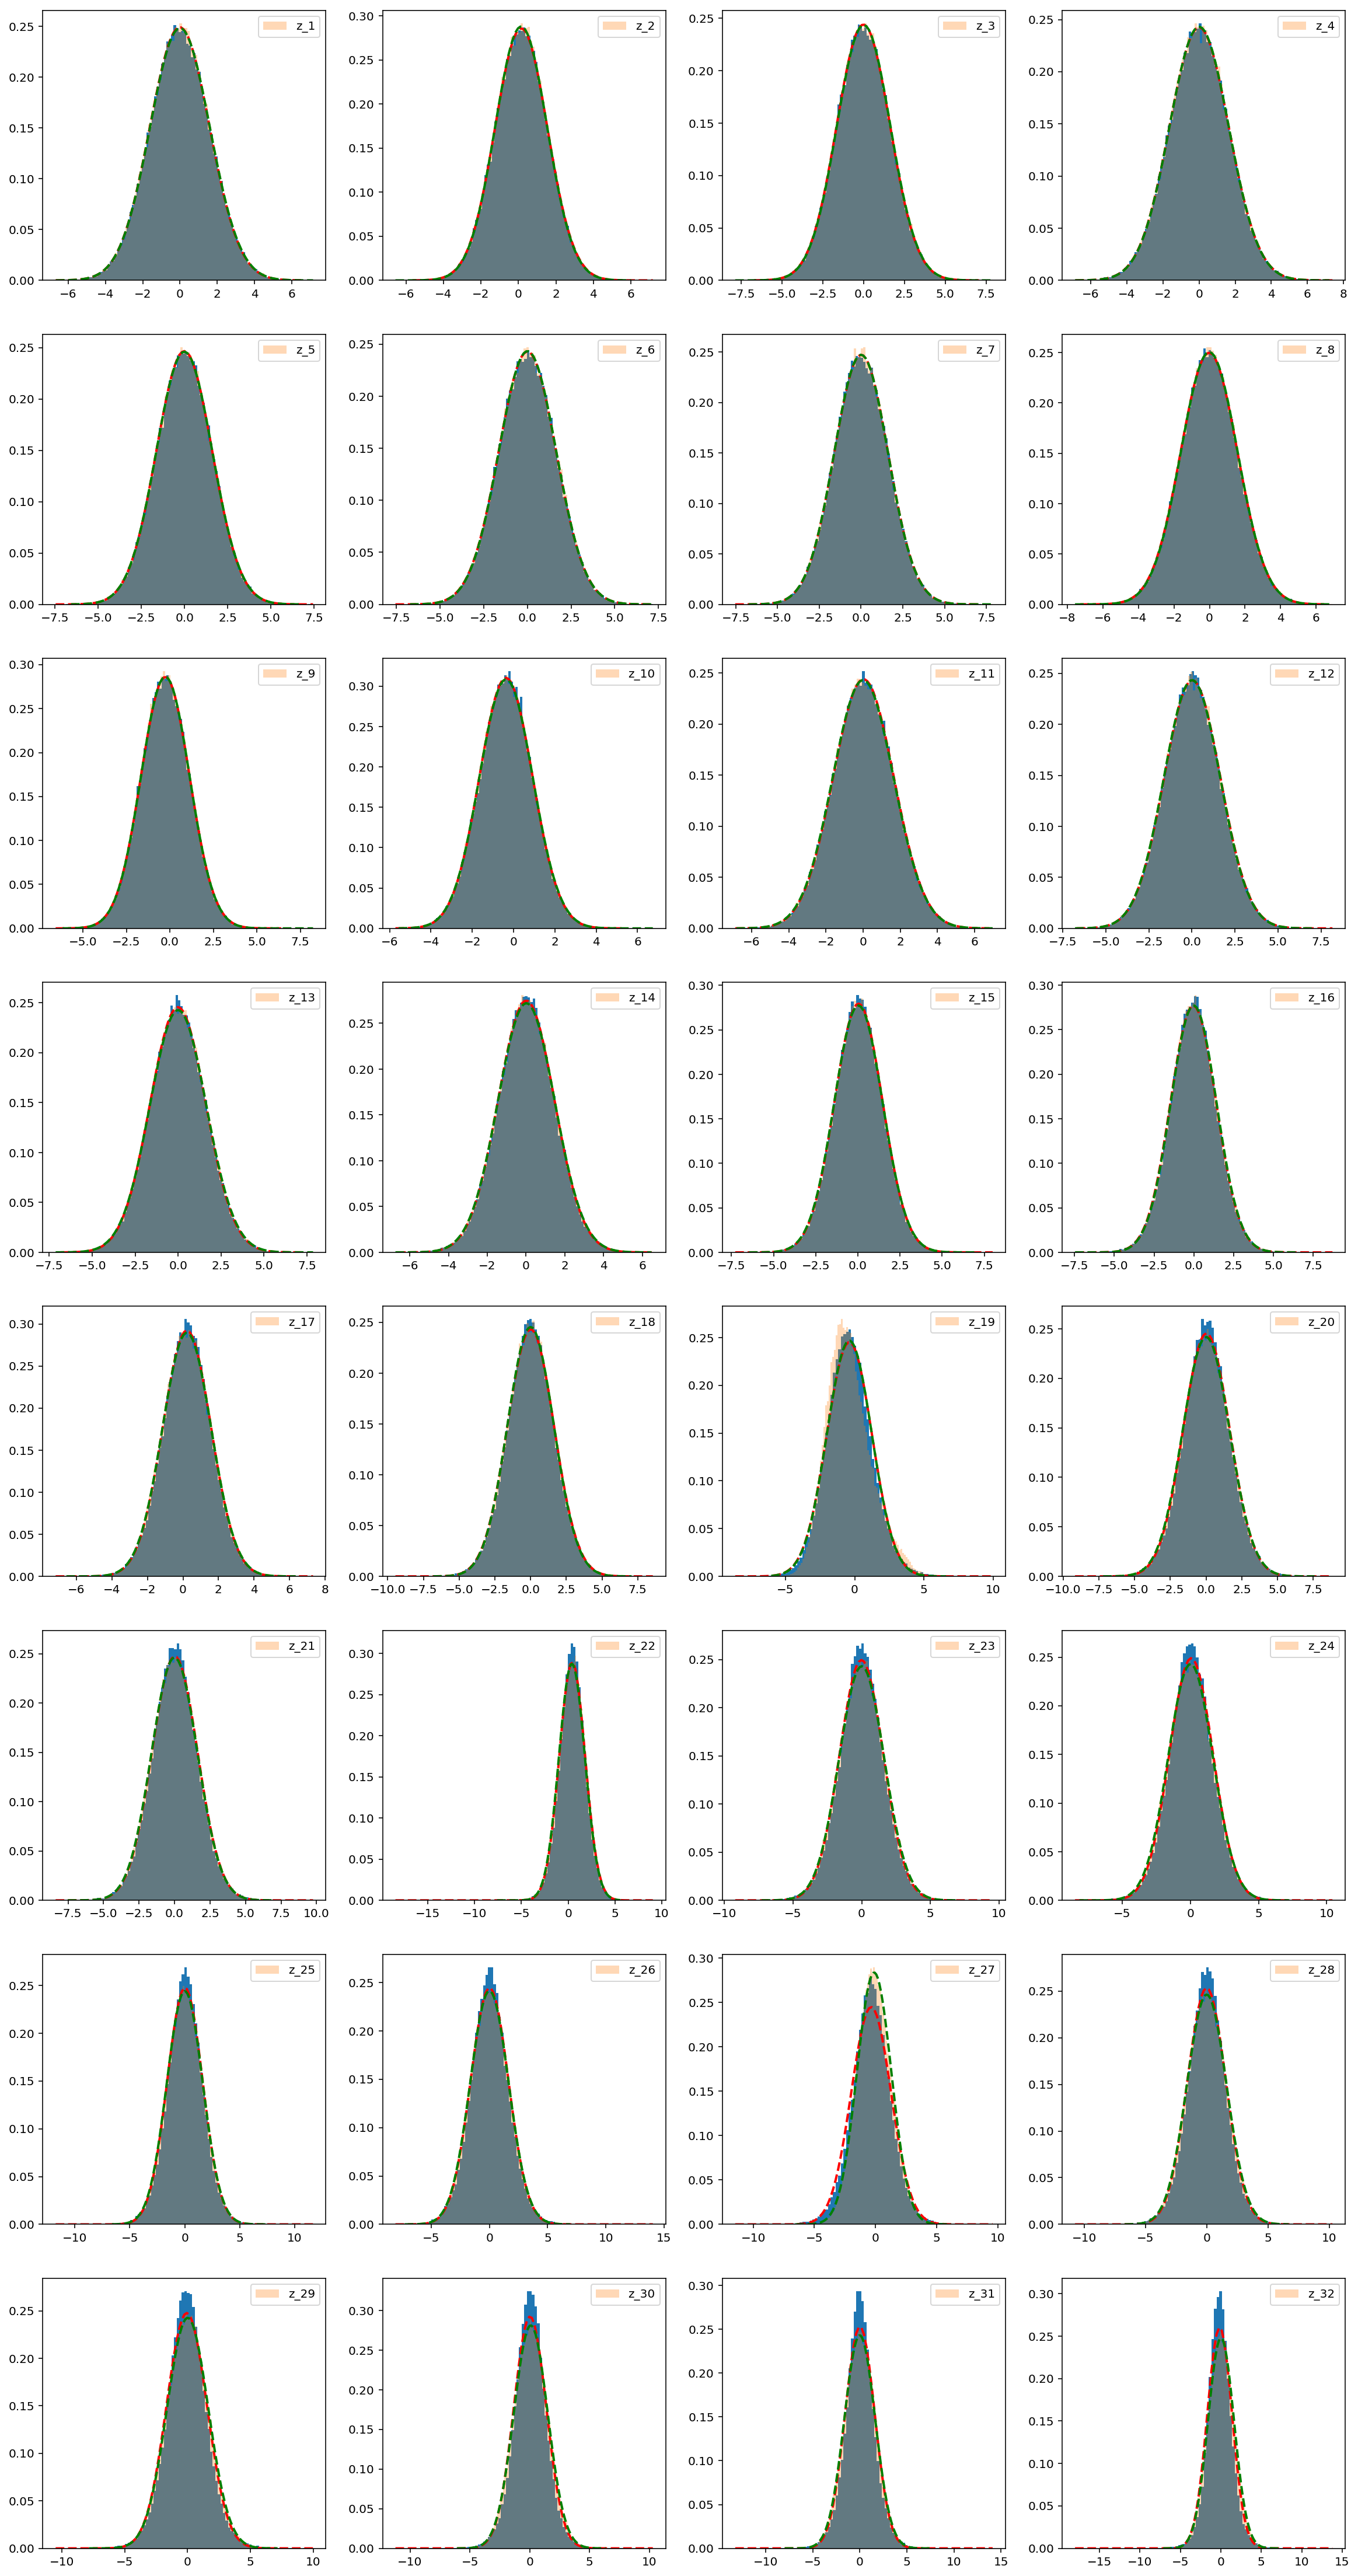

In [168]:
#z_test = StandardScaler().fit_transform(z[:,4:6])

fig, axes = plt.subplots(8,4, figsize = (20,40))

for i in range (8):
    for j in range (4):
        print(i*4+j)
        (mu, sigma) = norm.fit(samples[:,i*4+j])
        n, bins, patches = axes[i,j].hist(samples[:,i*4+j], normed = True, bins = 100)
        z_plt = mlab.normpdf( bins, mu, sigma)

        axes[i,j].plot(bins, z_plt, 'r--', linewidth=2)
        print('mu distrib transformed: '+str(mu)+' sigma distrib transformed: '+str(sigma))

        (mu, sigma) = norm.fit(z[:,i*4+j])
        n, bins, patches = axes[i,j].hist(z[:,i*4+j], normed = True, bins = 100, alpha = 0.3, label = 'z_'+str(i*4+j+1))
        z_plt = mlab.normpdf( bins, mu, sigma)

        axes[i,j].plot(bins, z_plt, 'g--', linewidth=2)
        print('mu z: '+str(mu)+' sigma z: '+str(sigma))
        axes[i,j].legend()

## Test with maf from Tensorflow example page (add ref)

In [21]:
maf = tfb.MaskedAutoregressiveFlow(
        shift_and_log_scale_fn=tfb.AutoregressiveNetwork(
            params=2, hidden_units=[512,512]))

In [22]:
made = tfb.AutoregressiveNetwork(params=2, hidden_units=[512,512])
maf_2 = tfb.MaskedAutoregressiveFlow(lambda y: (made(y)[..., 0], None),is_constant_jacobian=True)

In [23]:
invert_maf = tfb.Invert(tfb.MaskedAutoregressiveFlow(
        shift_and_log_scale_fn=tfb.AutoregressiveNetwork(
            params=2, hidden_units=[512, 512])))

In [24]:
hidden_dim = [512,512,512]
print(len(hidden_dim))
layers = 1
bijectors = []
for i in range(0, layers):
    bijectors.append(maf)
    #bijectors.append(maf_2)
    #bijectors.append(invert_maf)
    
bijectors = tfb.Chain(bijectors=bijectors)

3


In [25]:
distribution = tfd.TransformedDistribution(
    distribution=tfd.Normal(loc=0., scale=1.),
    bijector=bijectors,
    event_shape=[2]
)

W1204 18:18:00.609093 140404832835392 deprecation.py:323] From /sps/lsst/users/barcelin/miniconda/envs/python_cpu6/lib/python3.6/site-packages/tensorflow_probability/python/bijectors/masked_autoregressive.py:310: AffineScalar.__init__ (from tensorflow_probability.python.bijectors.affine_scalar) is deprecated and will be removed after 2020-01-01.
Instructions for updating:
`AffineScalar` bijector is deprecated; please use `tfb.Shift(loc)(tfb.Scale(...))` instead.


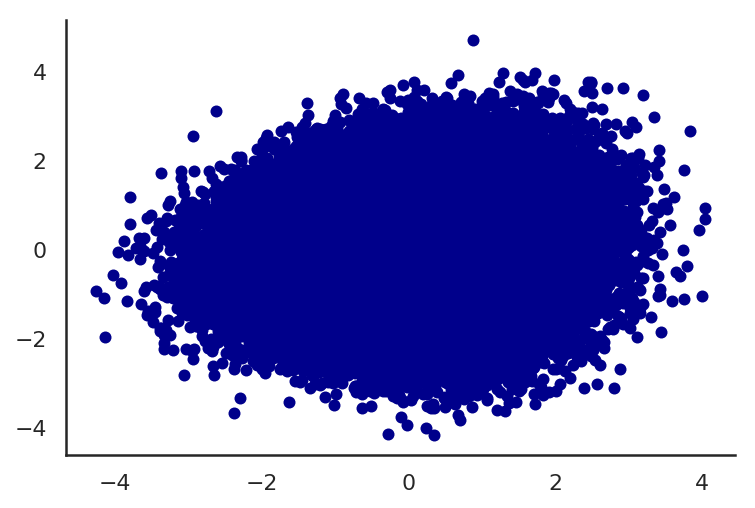

In [26]:
samples = distribution.sample(100000)

sns.scatterplot(samples[:, 0], samples[:, 1], color='darkblue', marker='o', linewidth=0);
sns.despine();

/sps/lsst/users/barcelin/miniconda/envs/python_cpu6/lib/python3.6/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  


mu: -0.0012086785 sigma: 1.0005544
mu: 0.0047245496 sigma: 1.0075555


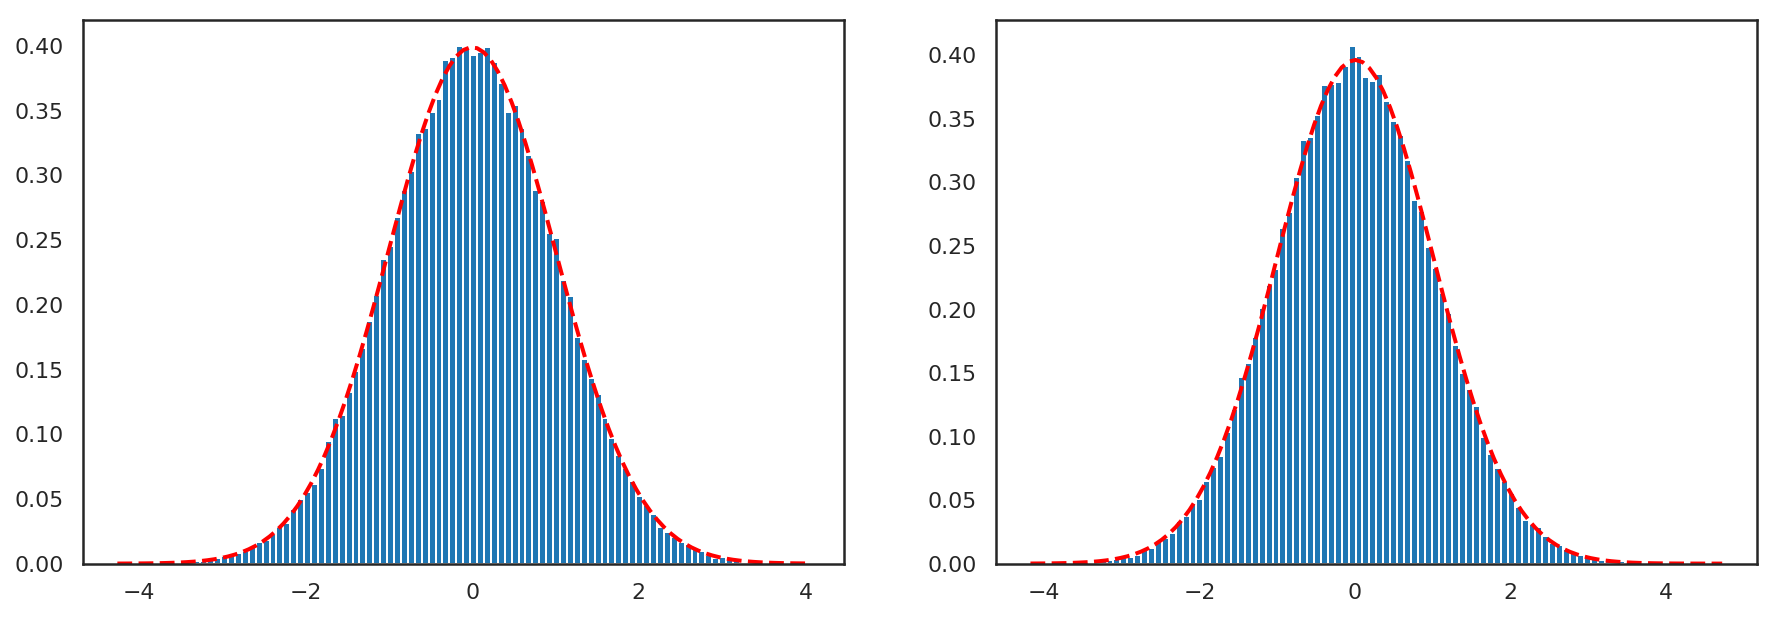

In [27]:
fig, axes = plt.subplots(1,2, figsize = (15,5))

for i in range (2):
    (mu, sigma) = norm.fit(samples[:,i])
    n, bins, patches = axes[i].hist(samples[:,i], normed = True, bins = 100)
    z_plt = mlab.normpdf( bins, mu, sigma)

    axes[i].plot(bins, z_plt, 'r--', linewidth=2)
    print('mu: '+str(mu)+' sigma: '+str(sigma))

In [28]:
x_ = tfkl.Input(shape=(2,), dtype=tf.float32)
log_prob_ = distribution.log_prob(x_)
model = tfk.Model(x_, log_prob_)

model.compile(optimizer=tf.optimizers.Adam(), loss=lambda _, log_prob: -log_prob)

In [29]:
_ = model.fit(x=z[:10000,:2],
              y=np.zeros((z[:10000,:2].shape[0], 0), dtype=np.float32),
              batch_size= z[:10000,:2].shape[0],
              epochs=500,
              steps_per_epoch=1,
              verbose=1,
              shuffle=False)

Train on 10000 samples
Epoch 1/500
10000/10000 [==============================] - 1s 90us/sample - loss: 4.1284
Epoch 2/500
10000/10000 [==============================] - 0s 14us/sample - loss: 14.9098
Epoch 3/500
10000/10000 [==============================] - 0s 14us/sample - loss: 4.0731
Epoch 4/500
10000/10000 [==============================] - 0s 15us/sample - loss: 4.5855
Epoch 5/500
10000/10000 [==============================] - 0s 13us/sample - loss: 10.7929
Epoch 6/500
10000/10000 [==============================] - 0s 13us/sample - loss: 11.7197
Epoch 7/500
10000/10000 [==============================] - 0s 16us/sample - loss: 5.7978
Epoch 8/500
10000/10000 [==============================] - 0s 14us/sample - loss: 4.3406
Epoch 9/500
10000/10000 [==============================] - 0s 14us/sample - loss: 4.0020
Epoch 10/500
10000/10000 [==============================] - 0s 13us/sample - loss: 3.9491
Epoch 11/500
10000/10000 [==============================] - 0s 14us/sample - loss: 

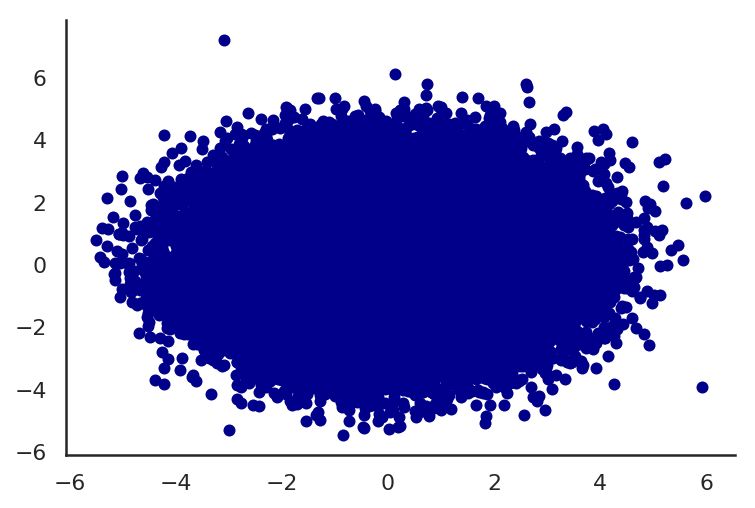

In [30]:
samples = distribution.sample(100000)
#samples = StandardScaler().fit_transform(samples)
sns.scatterplot(samples[:, 0], samples[:, 1], color='darkblue', marker='o', linewidth=0);
sns.despine();

/sps/lsst/users/barcelin/miniconda/envs/python_cpu6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/sps/lsst/users/barcelin/miniconda/envs/python_cpu6/lib/python3.6/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  
/sps/lsst/users/barcelin/miniconda/envs/python_cpu6/lib/python3.6/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  from ipykernel import kernelapp as app


mu distrib transformed: -0.03600198 sigma distrib transformed: 1.4055878
mu z: -0.0029954666276466417 sigma z: 1.606304417544382
mu distrib transformed: 0.15015724 sigma distrib transformed: 1.3835365
mu z: 0.14648211557320126 sigma z: 1.385527738249563


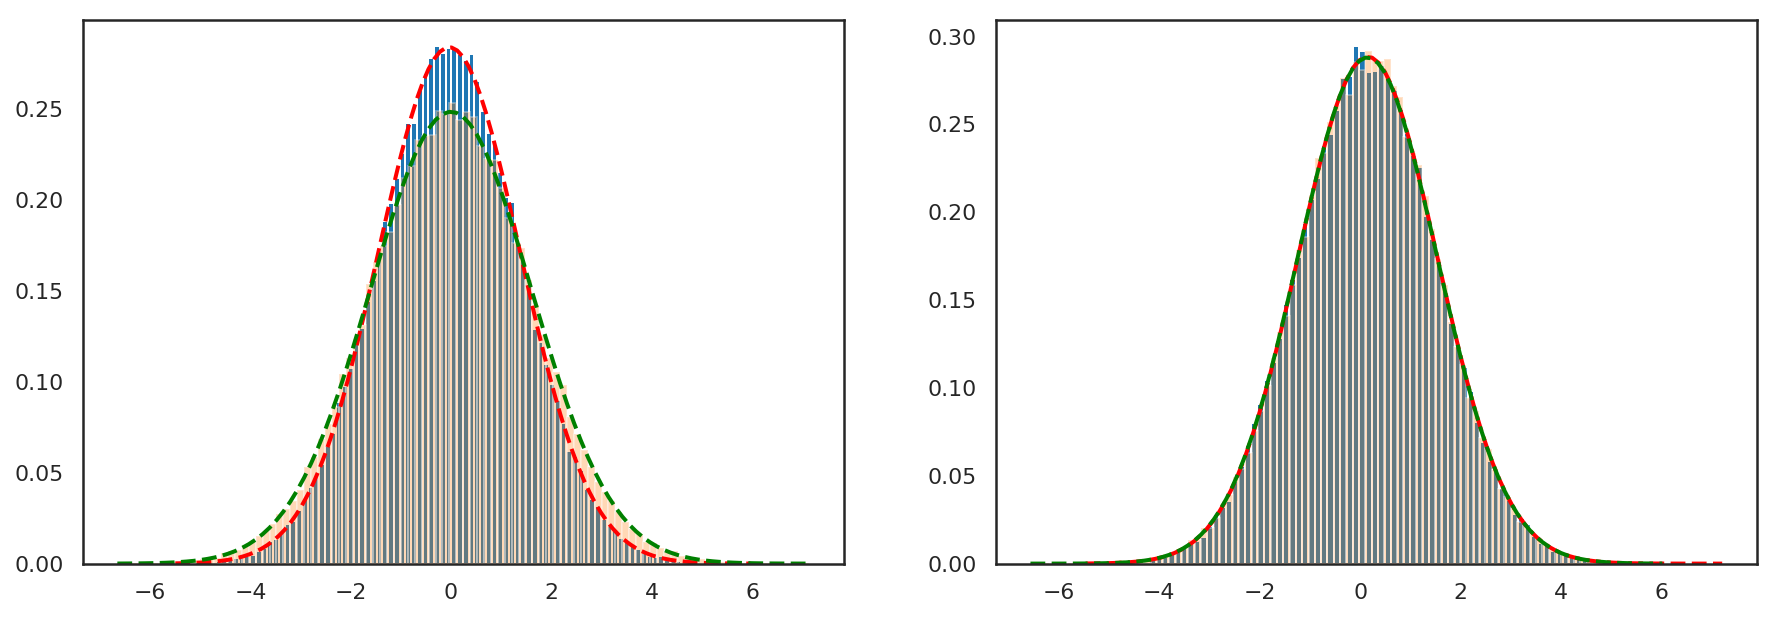

In [31]:
#z_test = StandardScaler().fit_transform(z[:,4:6])

fig, axes = plt.subplots(1,2, figsize = (15,5))

for i in range (2):
    (mu, sigma) = norm.fit(samples[:,i])
    n, bins, patches = axes[i].hist(samples[:,i], normed = True, bins = 100)
    z_plt = mlab.normpdf( bins, mu, sigma)

    axes[i].plot(bins, z_plt, 'r--', linewidth=2)
    print('mu distrib transformed: '+str(mu)+' sigma distrib transformed: '+str(sigma))
    
    (mu, sigma) = norm.fit(z[:,i])
    n, bins, patches = axes[i].hist(z[:,i], normed = True, bins = 100, alpha = 0.3)
    z_plt = mlab.normpdf( bins, mu, sigma)

    axes[i].plot(bins, z_plt, 'g--', linewidth=2)
    print('mu z: '+str(mu)+' sigma z: '+str(sigma))

## All dimensions of latent space

In [32]:
maf = tfb.MaskedAutoregressiveFlow(
        shift_and_log_scale_fn=tfb.AutoregressiveNetwork(
            params=2, hidden_units=[1024,1024]))

In [33]:
hidden_dim = [512,512,512]
print(len(hidden_dim))
layers = 1
bijectors = []
for i in range(0, layers):
    #made = make_network(3, hidden_dim, 3)
    #bijectors.append(MAF(made))
    bijectors.append(maf)
    #bijectors.append(tfb.Permute(permutation=[1, 0])) 
    
#bijectors = tfb.Chain(bijectors=list(reversed(bijectors[:-1])))
bijectors = tfb.Chain(bijectors=bijectors)

3


In [34]:
new_distribution = tfd.TransformedDistribution(
    distribution=tfd.Normal(loc=0., scale=1.),
    bijector=bijectors,
    event_shape=[32]
)

hidden_dim = [512,512,512,512,512,512,512,512,512,512,512,512,512,512,512,512,512,
             512,512,512,512,512,512,512,512,512,512,512,512,512,512,512]
print(len(hidden_dim))
layers = 2
bijectors = []
for i in range(0, layers):
    made = make_network(2, hidden_dim, 2)
    bijectors.append(MAF(made))
    bijectors.append(tfb.Permute(permutation=[1, 0])) 
    
#bijectors = tfb.Chain(bijectors=list(reversed(bijectors[:-1])))
bijectors = tfb.Chain(bijectors=bijectors)

tfd.TransformedDistribution(
    distribution=tfd.Normal(loc=0., scale=1.),
    bijector=bijectors,
   event_shape=[32]
).sample(2)

In [35]:
samples = new_distribution.sample(1000)

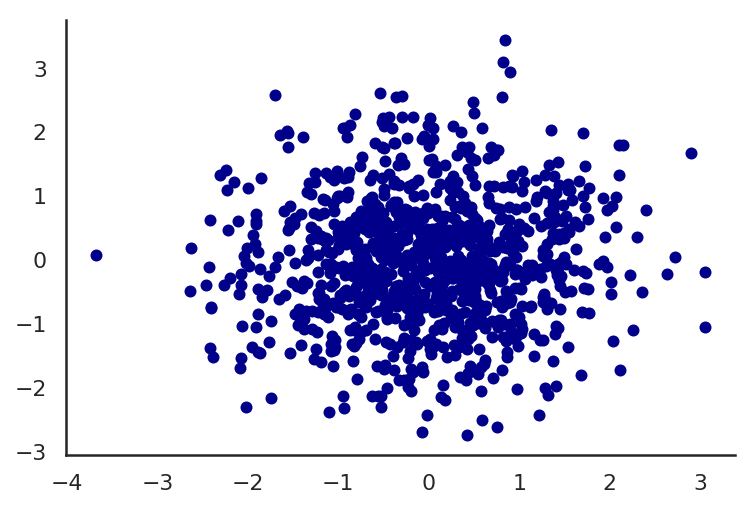

In [36]:
samples = new_distribution.sample(1000)

sns.scatterplot(samples[:, 0], samples[:, 1], color='darkblue', marker='o', linewidth=0);
sns.despine();

In [37]:
x_ = tfkl.Input(shape=(32,), dtype=tf.float32)
log_prob_ = new_distribution.log_prob(x_)
model = tfk.Model(x_, log_prob_)

model.compile(optimizer=tf.optimizers.Adam(), loss=lambda _, log_prob: -log_prob)

In [38]:
z.shape

(100000, 32)

In [39]:
z_2 = z[:10000]#.reshape((16000,2))

In [40]:
_ = model.fit(x=z_2,
              y=np.zeros((z_2.shape[0], 0), dtype=np.float32),
              batch_size= z_2.shape[0],
              epochs=1000,
              steps_per_epoch=1,
              verbose=1,
              shuffle=False)

Train on 10000 samples
Epoch 1/1000
10000/10000 [==============================] - 3s 279us/sample - loss: 69.9499
Epoch 2/1000
10000/10000 [==============================] - 0s 50us/sample - loss: 68.6621
Epoch 3/1000
10000/10000 [==============================] - 1s 51us/sample - loss: 67.8987
Epoch 4/1000
10000/10000 [==============================] - 0s 48us/sample - loss: 67.4084
Epoch 5/1000
10000/10000 [==============================] - 1s 52us/sample - loss: 66.9278
Epoch 6/1000
10000/10000 [==============================] - 1s 57us/sample - loss: 66.4526
Epoch 7/1000
10000/10000 [==============================] - 1s 58us/sample - loss: 65.9809
Epoch 8/1000
10000/10000 [==============================] - 1s 51us/sample - loss: 65.5038
Epoch 9/1000
10000/10000 [==============================] - 0s 50us/sample - loss: 65.0090
Epoch 10/1000
10000/10000 [==============================] - 0s 47us/sample - loss: 64.4941
Epoch 11/1000
10000/10000 [==============================] - 0s 4

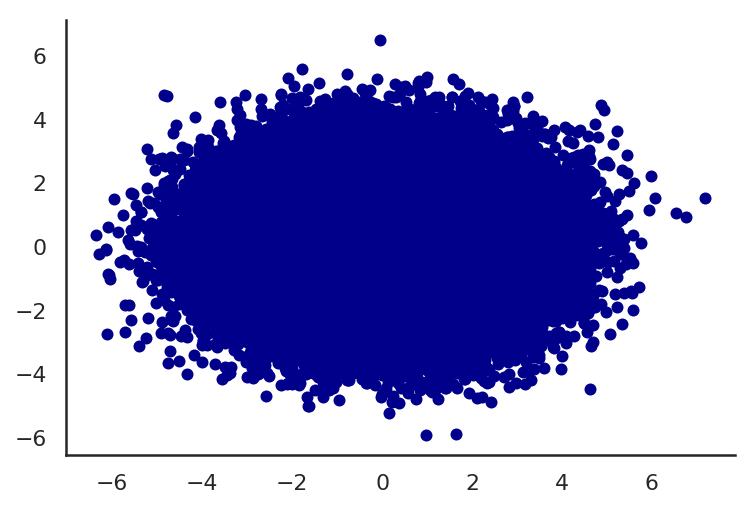

In [41]:
# 1 layer: 58.7803
# 3 layers: 58.7858
# 10 layers: 58.7873

samples = new_distribution.sample(100000)

sns.scatterplot(samples[:, 0], samples[:, 1], color='darkblue', marker='o', linewidth=0);
sns.despine();

0
mu distrib transformed: -0.03650973 sigma distrib transformed: 1.5702083
mu z: -0.0029954666276466417 sigma z: 1.606304417544382
1


/sps/lsst/users/barcelin/miniconda/envs/python_cpu6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/sps/lsst/users/barcelin/miniconda/envs/python_cpu6/lib/python3.6/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  # Remove the CWD from sys.path while we load stuff.
/sps/lsst/users/barcelin/miniconda/envs/python_cpu6/lib/python3.6/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: scipy.stats.norm.pdf


mu distrib transformed: 0.14047746 sigma distrib transformed: 1.381041
mu z: 0.14648211557320126 sigma z: 1.385527738249563
2
mu distrib transformed: -0.012733145 sigma distrib transformed: 1.6238196
mu z: -0.002404891142242835 sigma z: 1.63748863033781
3
mu distrib transformed: 0.018983476 sigma distrib transformed: 1.6317471
mu z: 0.0017612746283812263 sigma z: 1.6409900300761895
4
mu distrib transformed: -0.027980343 sigma distrib transformed: 1.6112607
mu z: -0.01107336978452871 sigma z: 1.6214101027101977
5
mu distrib transformed: -0.0012019026 sigma distrib transformed: 1.6580681
mu z: 0.005062652777217738 sigma z: 1.6389593598966976
6
mu distrib transformed: 0.0114321215 sigma distrib transformed: 1.6061931
mu z: 0.0036206782367795153 sigma z: 1.6127996757595864
7
mu distrib transformed: 0.011416033 sigma distrib transformed: 1.5930952
mu z: -0.012937840779428594 sigma z: 1.5923759133557371
8
mu distrib transformed: -0.2661469 sigma distrib transformed: 1.3816103
mu z: -0.262835

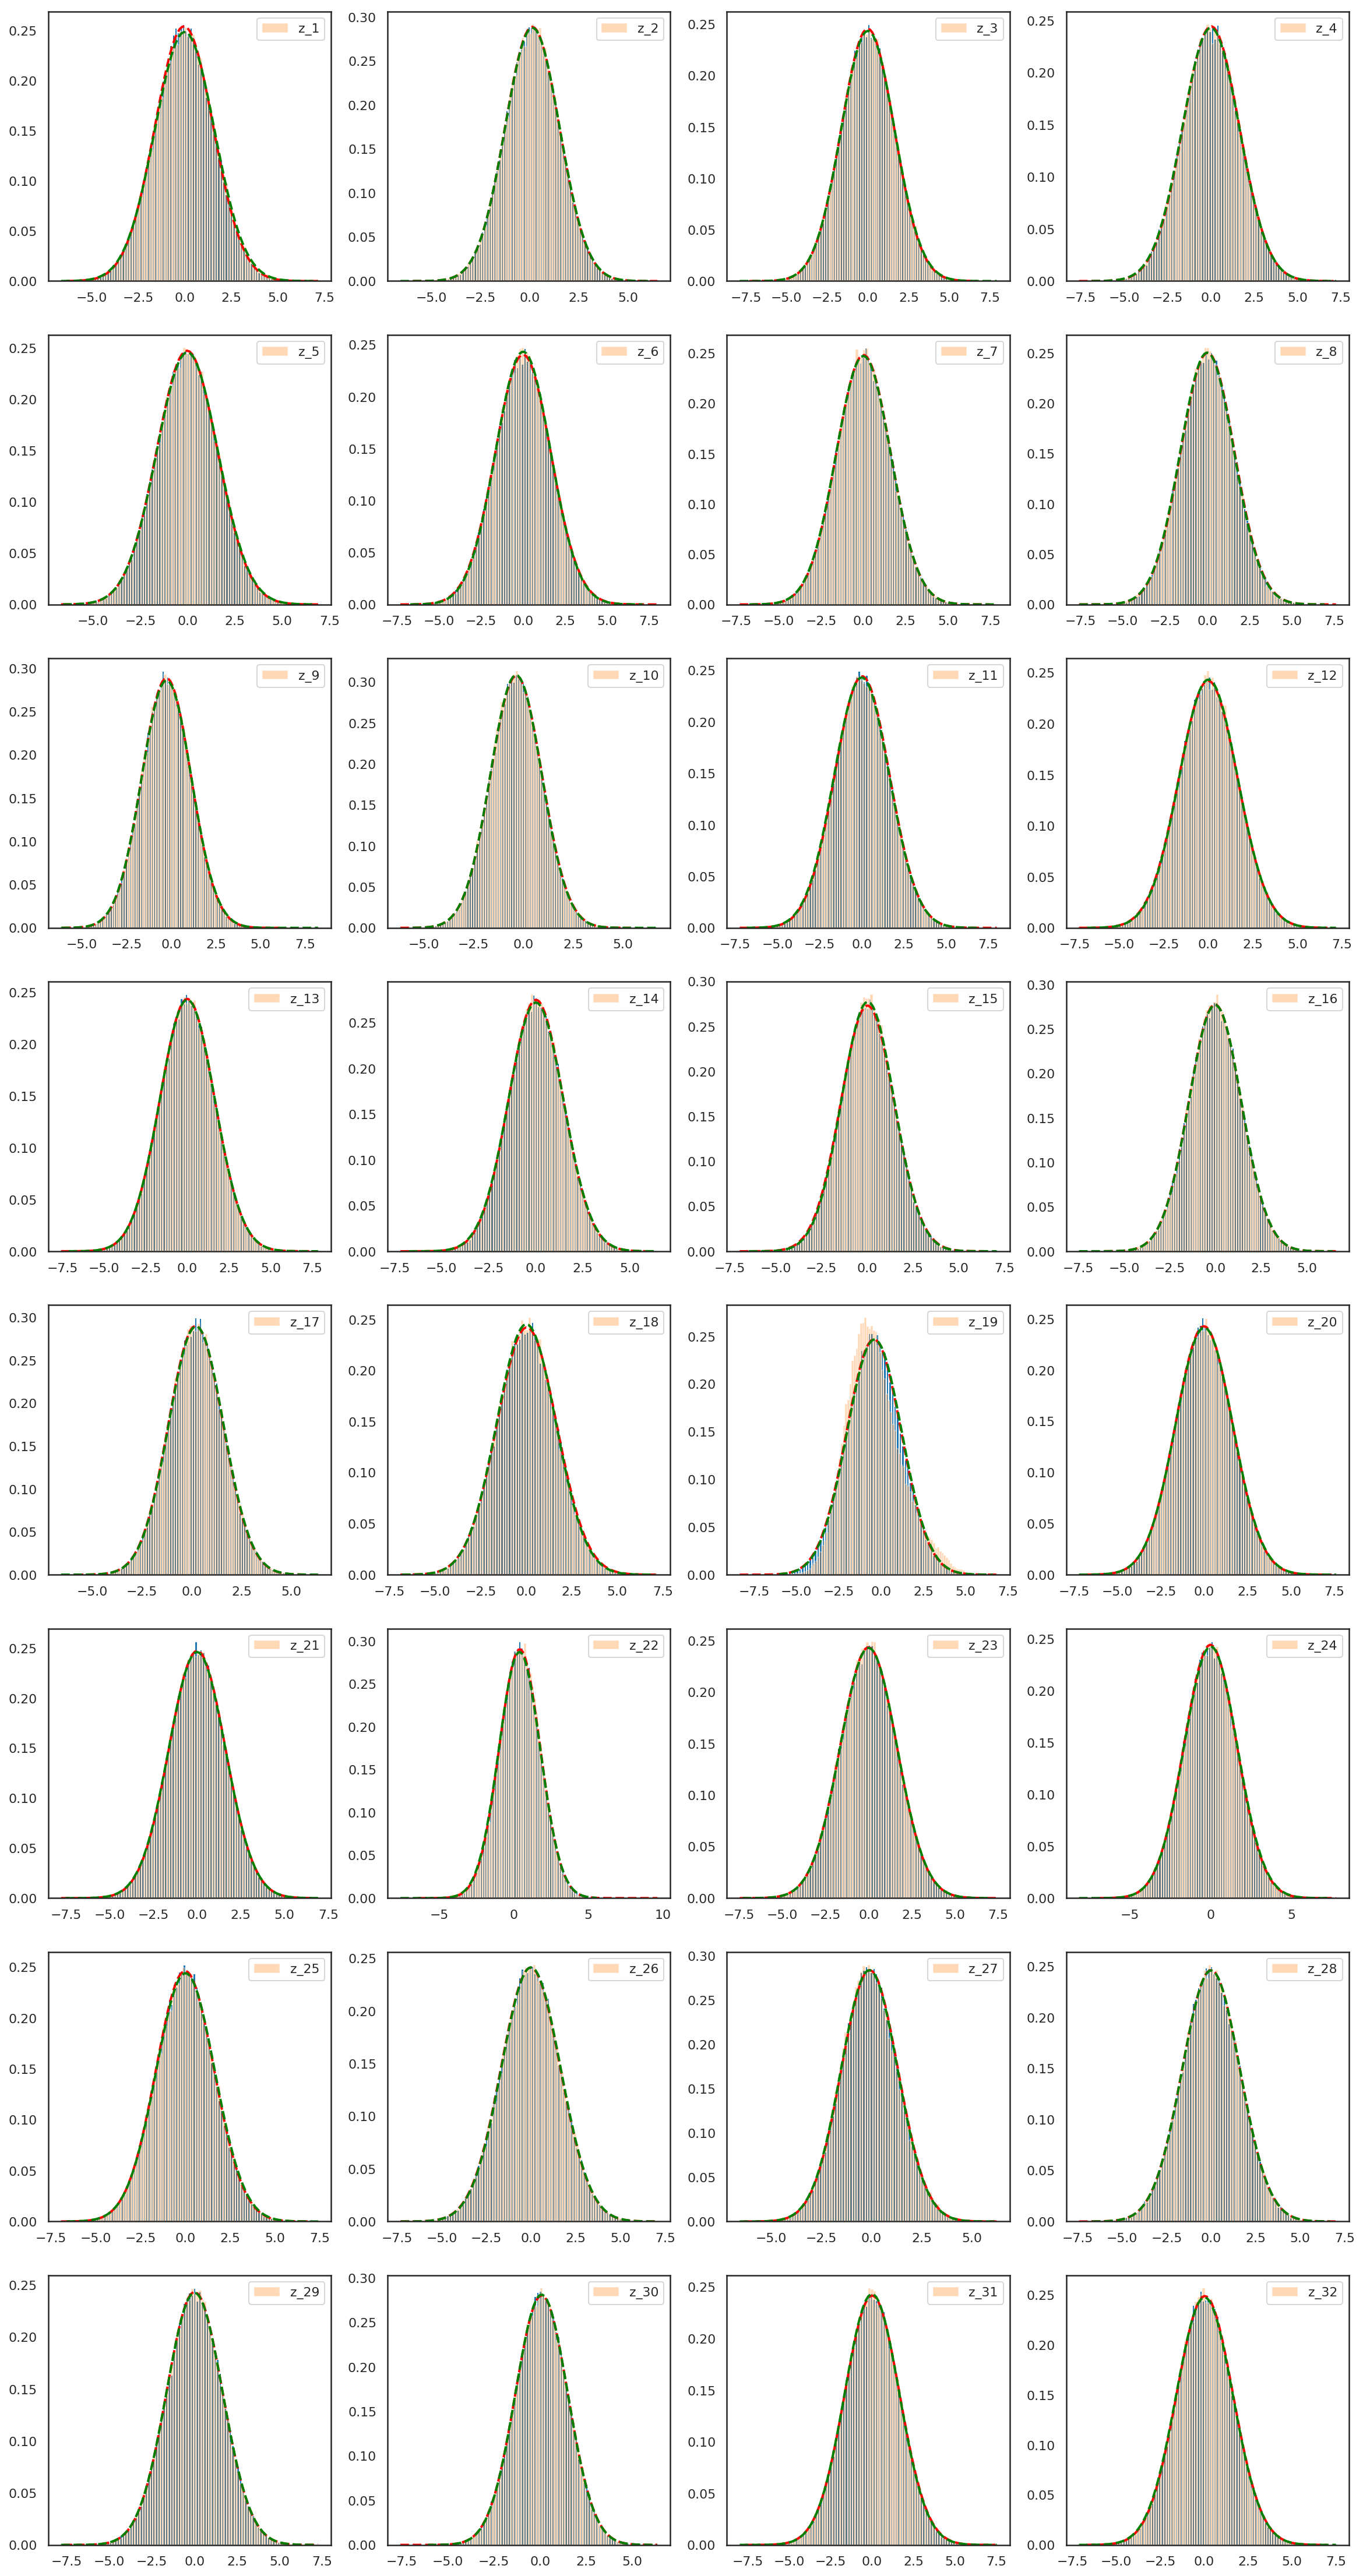

In [42]:
#z_test = StandardScaler().fit_transform(z[:,4:6])

fig, axes = plt.subplots(8,4, figsize = (20,40))

for i in range (8):
    for j in range (4):
        print(i*4+j)
        (mu, sigma) = norm.fit(samples[:,i*4+j])
        n, bins, patches = axes[i,j].hist(samples[:,i*4+j], normed = True, bins = 100)
        z_plt = mlab.normpdf( bins, mu, sigma)

        axes[i,j].plot(bins, z_plt, 'r--', linewidth=2)
        print('mu distrib transformed: '+str(mu)+' sigma distrib transformed: '+str(sigma))

        (mu, sigma) = norm.fit(z[:,i*4+j])
        n, bins, patches = axes[i,j].hist(z[:,i*4+j], normed = True, bins = 100, alpha = 0.3, label = 'z_'+str(i*4+j+1))
        z_plt = mlab.normpdf( bins, mu, sigma)

        axes[i,j].plot(bins, z_plt, 'g--', linewidth=2)
        print('mu z: '+str(mu)+' sigma z: '+str(sigma))
        axes[i,j].legend()

## Test normalization to generate images

In [43]:
import sys
sys.path.insert(0,'Deblender_VAE/scripts/tools_for_VAE/')
from tools_for_VAE import utils

vae_lsst_conv,vae_lsst_utils, encoder_LSST, decoder_LSST, Dkl = utils.load_vae_full('/sps/lsst/users/barcelin/weights/LSST/VAE/noisy/v_2/v1/bis_bis_bis/mse/',6, folder= True)

W1204 18:28:57.324619 140404832835392 deprecation.py:506] From /sps/lsst/users/barcelin/miniconda/envs/python_cpu6/lib/python3.6/site-packages/tensorflow_core/python/ops/linalg/linear_operator_diag.py:166: calling LinearOperator.__init__ (from tensorflow.python.ops.linalg.linear_operator) with graph_parents is deprecated and will be removed in a future version.
Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


/sps/lsst/users/barcelin/weights/LSST/VAE/noisy/v_2/v1/bis_bis_bis/mse/


W1204 18:28:58.180394 140404832835392 util.py:148] Unused attribute in object (root): ['OBJECT_CONFIG_JSON']
W1204 18:28:58.181413 140404832835392 util.py:148] Unused attribute in object (root).layer-0: ['OBJECT_CONFIG_JSON']
W1204 18:28:58.182067 140404832835392 util.py:148] Unused attribute in object (root).layer_with_weights-0: ['OBJECT_CONFIG_JSON']
W1204 18:28:58.182620 140404832835392 util.py:148] Unused attribute in object (root).layer-2: ['OBJECT_CONFIG_JSON']
W1204 18:28:58.183103 140404832835392 util.py:148] Unused attribute in object (root).layer_with_weights-1: ['OBJECT_CONFIG_JSON']
W1204 18:28:58.183779 140404832835392 util.py:148] Unused attribute in object (root).layer_with_weights-0.layer-0: ['OBJECT_CONFIG_JSON']
W1204 18:28:58.184368 140404832835392 util.py:148] Unused attribute in object (root).layer_with_weights-0.layer-1: ['OBJECT_CONFIG_JSON']
W1204 18:28:58.184896 140404832835392 util.py:148] Unused attribute in object (root).layer_with_weights-0.layer_with_weig

In [44]:
out = decoder_LSST(samples[:100])

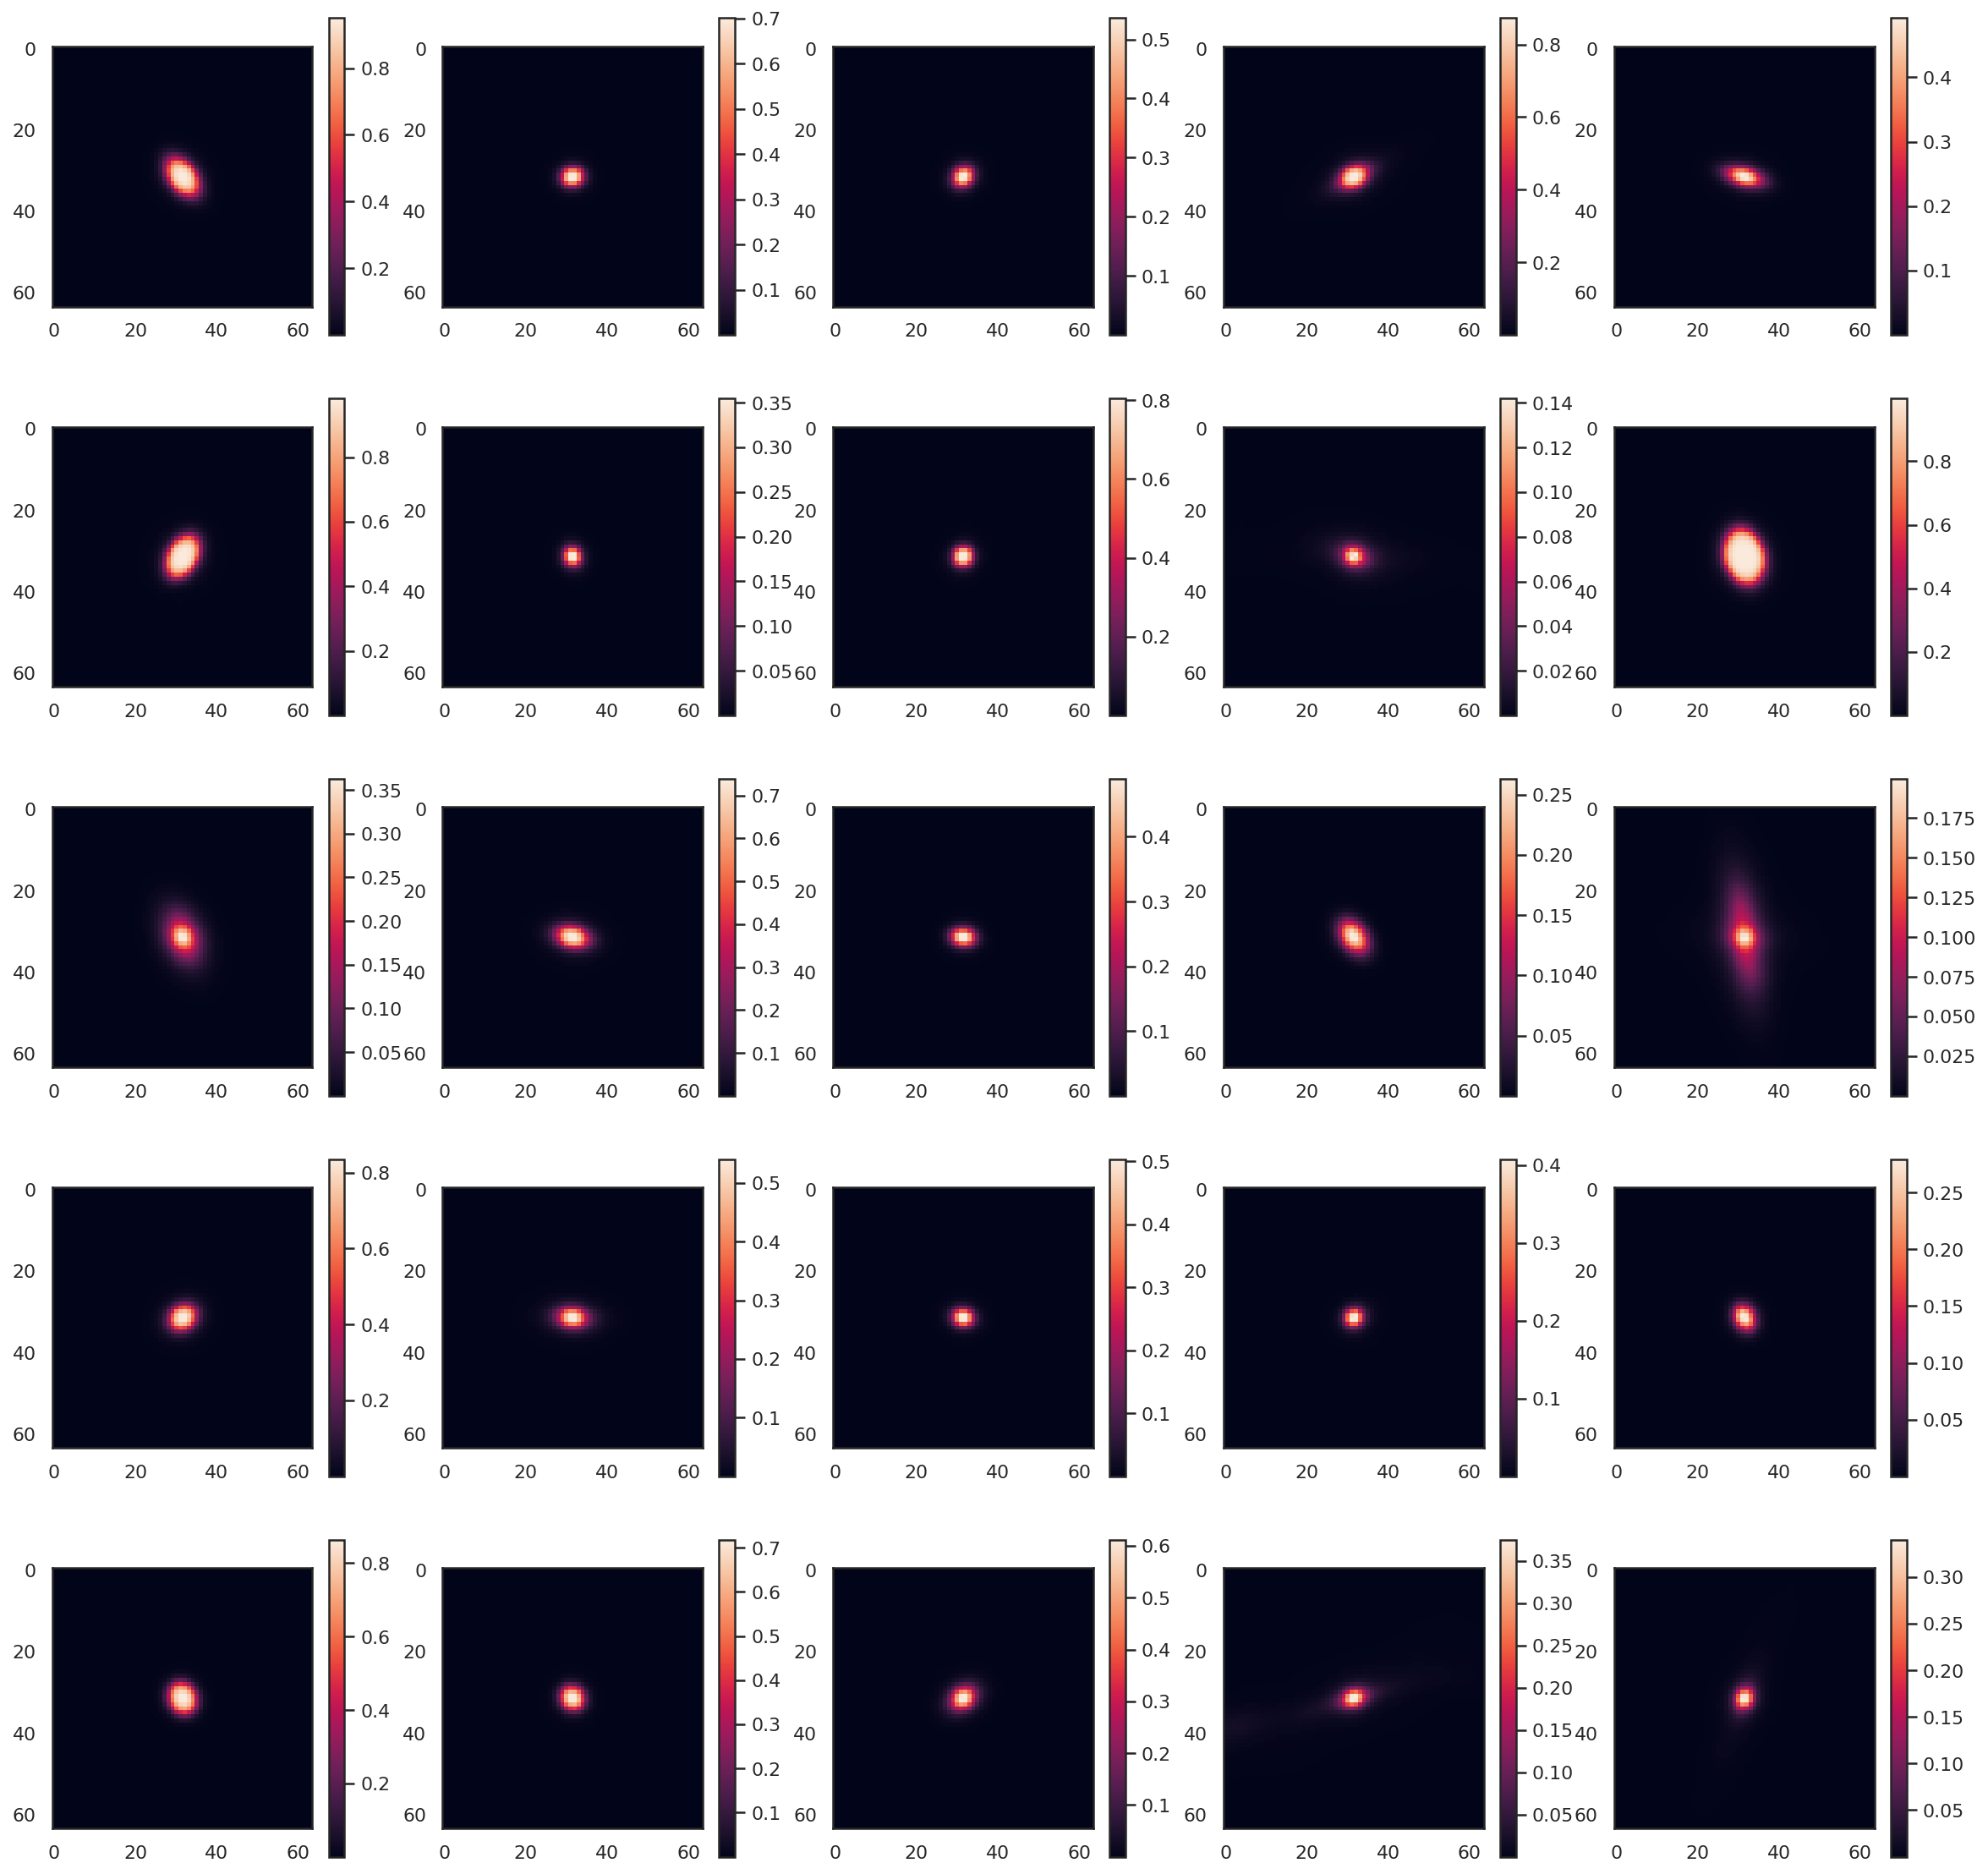

In [45]:
fig, axes = plt.subplots(5,5, figsize = (20,20))
for i in range (5):
    for j in range (5):
        fig_1 = axes[i,j].imshow(out[i*5+j,:,:,2])
        fig.colorbar(fig_1 ,ax=axes[i,j])

In [88]:
sys.path.insert(1,'Deblender_VAE/scripts/tools_for_VAE/')

from tools_for_VAE import plot, utils
from tensorflow.keras import backend as K

In [92]:
np.array(out).shape

(100, 64, 64, 6)

In [93]:
path = '/sps/lsst/users/barcelin/data/isolated_galaxies/27.5/centered/test/'
denorm = utils.denorm(np.array(out), bands = [0,1,2,3,4,5], path = path, channel_last=True)

(100, 64, 64, 6)


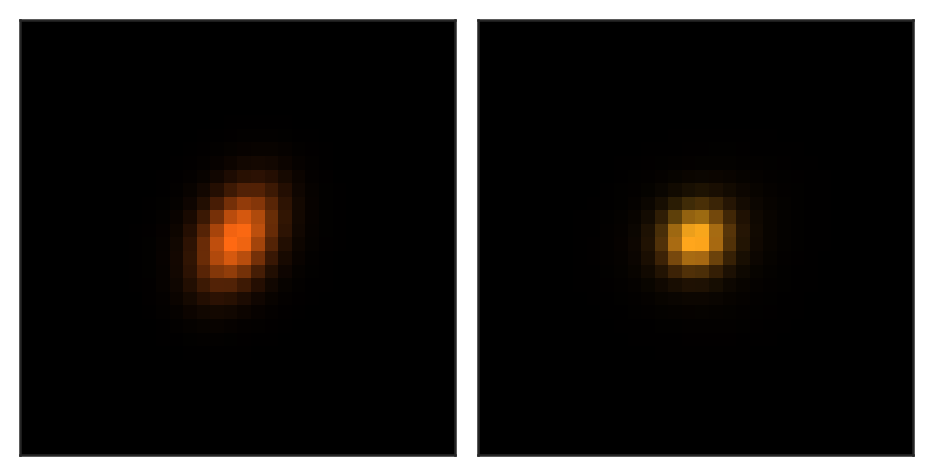

In [112]:
import matplotlib.gridspec as gridspec
bands=[1,2,3]
fig, axes = plt.subplots(1,2, figsize = (8,4))
gs1 = gridspec.GridSpec(1, 2)
gs1.update(wspace=0.05, hspace=0.05)

ax1 = plt.subplot(gs1[0])#axe[0]
ax1.imshow(np.clip(np.array(K.get_value(denorm[5]))[16:48,16:48,bands]/np.max(np.array(K.get_value(denorm[5]))[:,:,bands]), a_min=0.0, a_max=1.))
ax1.tick_params(axis='y', which='both',  left = False, labelleft=False)
ax1.tick_params(axis='x', which='both',bottom = False,labelbottom=False)
ax2 = plt.subplot(gs1[1])#axe[1]
ax2.imshow(np.clip(np.array(K.get_value(denorm[18]))[16:48,16:48,bands]/np.max(np.array(K.get_value(denorm[18]))[:,:,bands]), a_min=0.0, a_max=1.))
ax2.tick_params(axis='y', which='both',  left = False, labelleft=False)
ax2.tick_params(axis='x', which='both',bottom = False,labelbottom=False)
plt.savefig('/pbs/home/b/barcelin/pbs_throng_link/parameter_estimation/notebooks/parameter_estimation/imgs/gal_vae.pdf', dpi = 300)

Compare without normalization

W1204 18:29:05.532507 140404832835392 base_layer.py:1790] Layer dense_18 is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



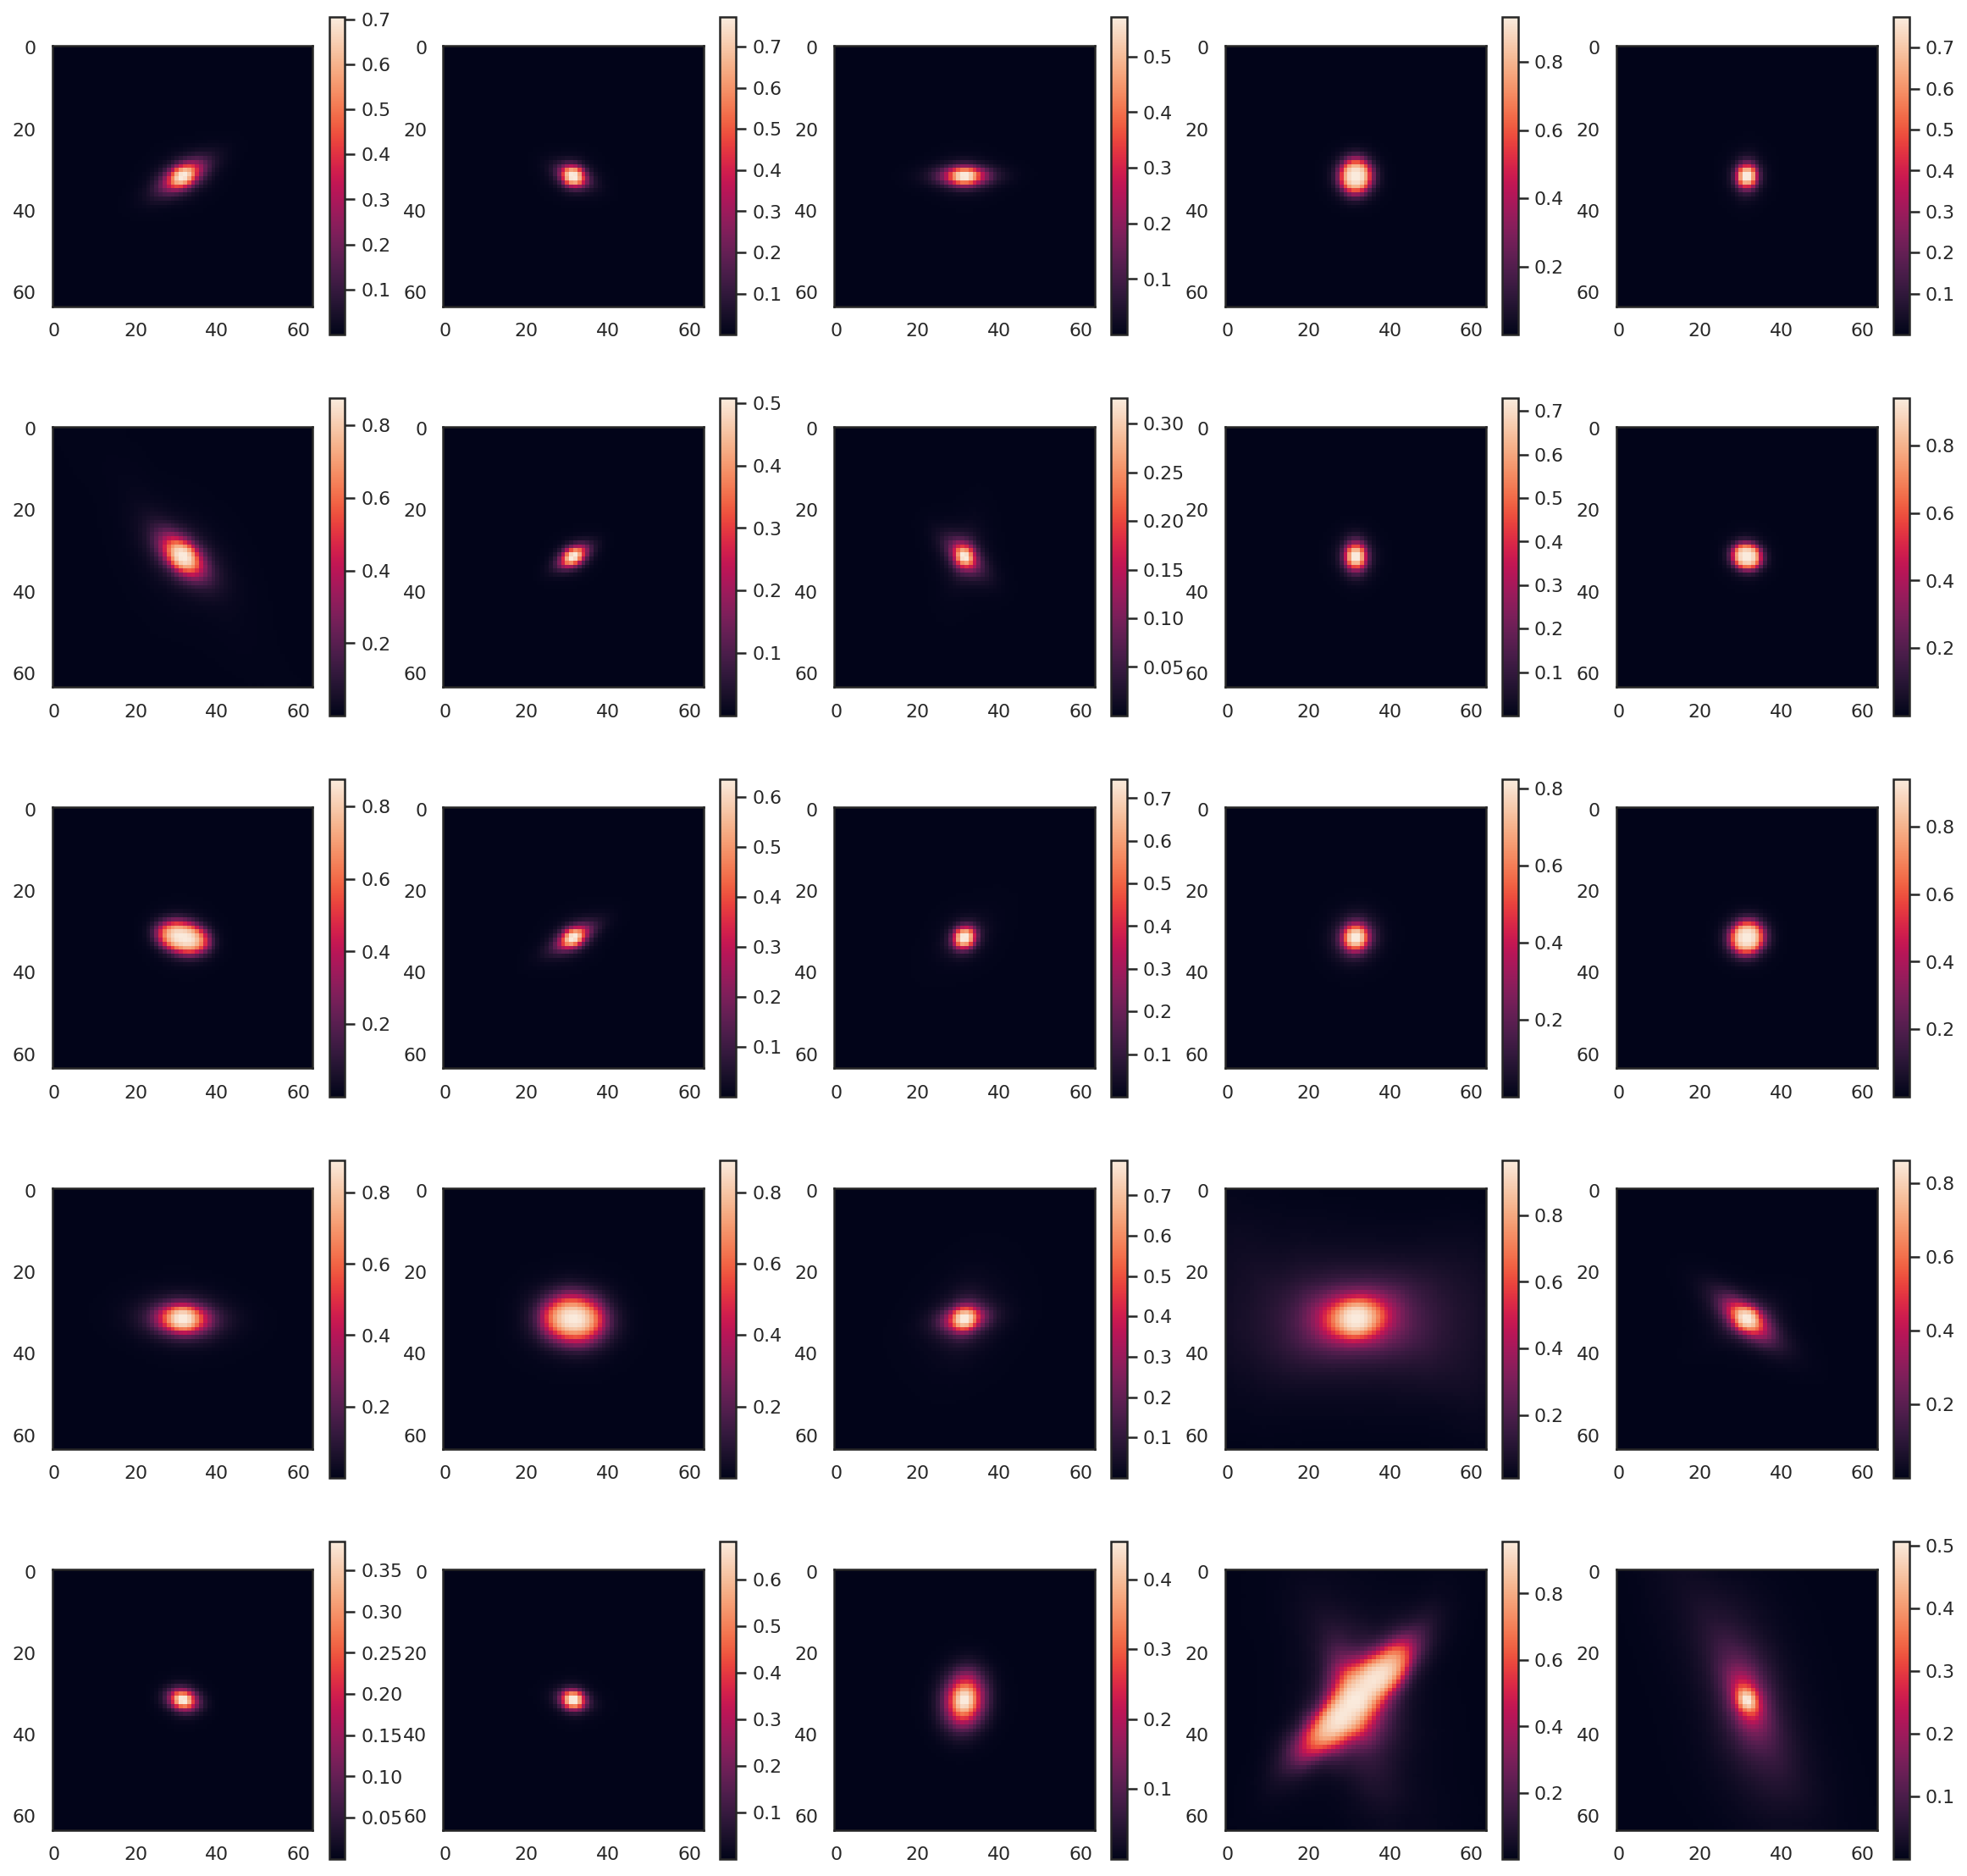

In [46]:
normal_sample = np.random.normal(loc=0.0, scale=1.0, size=(100,32))

out_no_transform = decoder_LSST(normal_sample)

fig, axes = plt.subplots(5,5, figsize = (20,20))
for i in range (5):
    for j in range (5):
        fig_1 = axes[i,j].imshow(out_no_transform[i*5+j,:,:,2])
        fig.colorbar(fig_1 ,ax=axes[i,j])